In [173]:
import pandas as pd
import numpy as np


In [174]:

df=pd.read_csv(r"C:\Users\hp\IDA_Stock_project\data_set_ida\main_data\.ipynb_checkpoints\cleaned_stock_data_updated-checkpoint.csv")

In [175]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 43196 entries, 0 to 43195
Data columns (total 9 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Unnamed: 0  43196 non-null  int64  
 1   Date        43196 non-null  object 
 2   Adj Close   43196 non-null  float64
 3   Close       43196 non-null  float64
 4   High        43196 non-null  float64
 5   Low         43196 non-null  float64
 6   Open        43196 non-null  float64
 7   Volume      43196 non-null  int64  
 8   Company     43196 non-null  object 
dtypes: float64(5), int64(2), object(2)
memory usage: 3.0+ MB


**Sample plots**

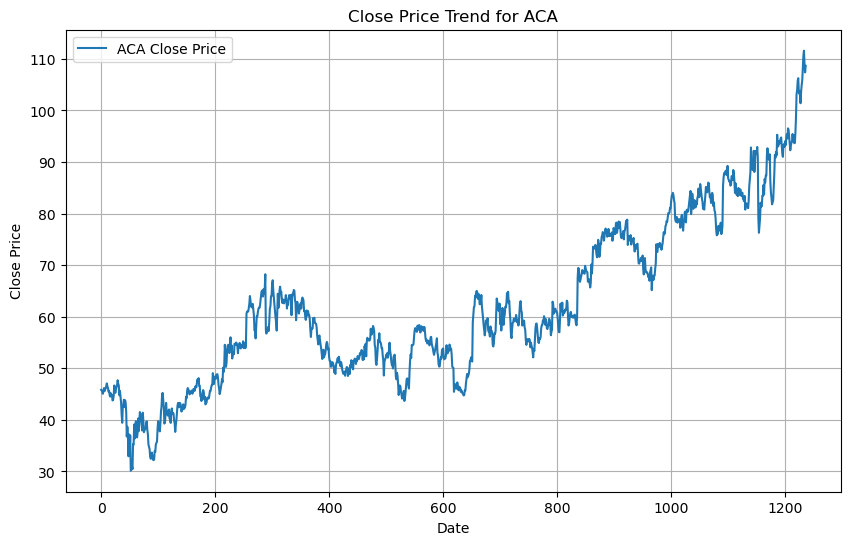

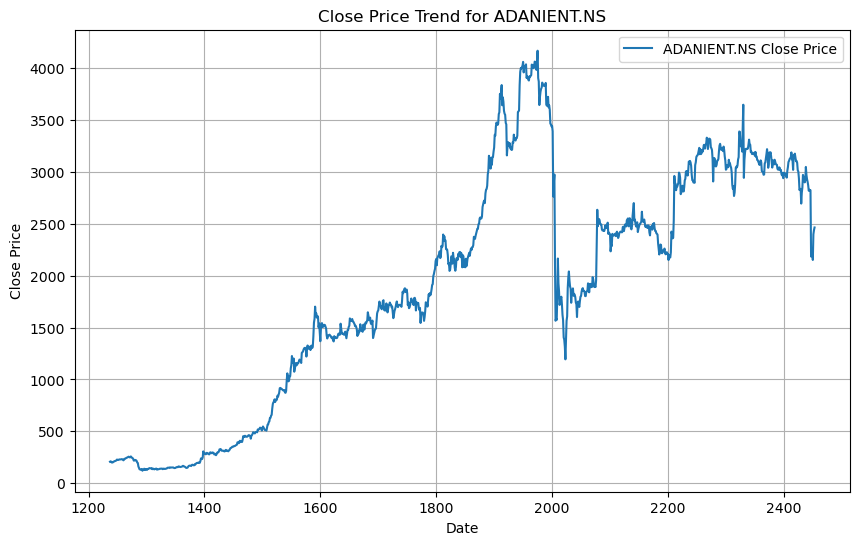

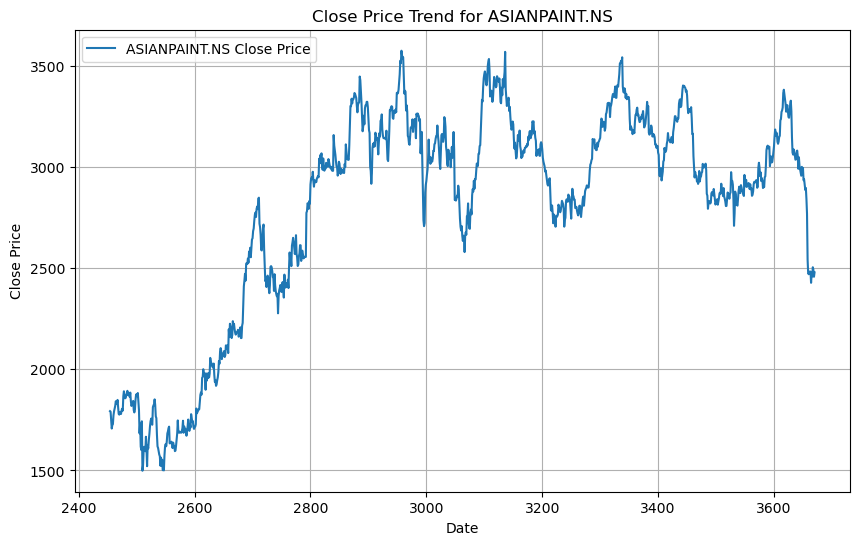

In [176]:
import matplotlib.pyplot as plt
grouped = df.groupby('Company')
for i, (company, group_data) in enumerate(grouped):
    if i == 3:  # Stop after plotting the first 3 companies
        break
    plt.figure(figsize=(10, 6))  # Create a new figure for each company
    plt.plot(group_data.index, group_data['Close'], label=f"{company} Close Price")
    plt.title(f"Close Price Trend for {company}")
    plt.xlabel("Date")
    plt.ylabel("Close Price")
    plt.legend()
    plt.grid(True)
    plt.show()


In [177]:
df['Date'] = pd.to_datetime(df['Date'])
start_date = pd.to_datetime('2024-05-29')
end_date = pd.to_datetime('2024-11-29')

final_test_data= df[(df['Date'] >= start_date) & (df['Date'] <= end_date)]    #TEST

df = df[(df['Date'] < start_date)]    #training


In [178]:
del df['Unnamed: 0']


In [179]:
df['Target'] = (df['Adj Close'].shift(-30) > df['Adj Close']).astype(int)


C:\Users\hp\AppData\Local\Temp\ipykernel_9264\153744130.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Target'] = (df['Adj Close'].shift(-30) > df['Adj Close']).astype(int)


<Axes: xlabel='Target'>

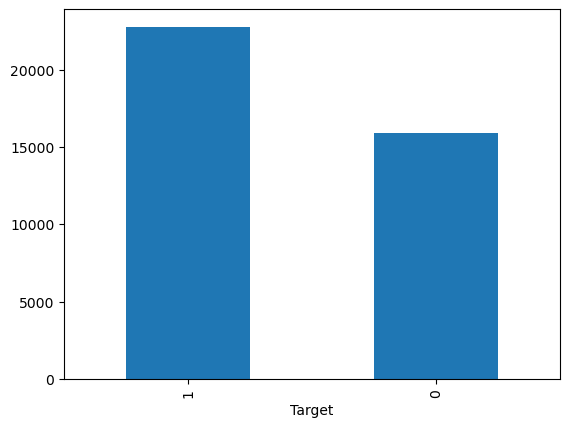

In [180]:
df['Target'].value_counts().plot(kind='bar')


In [181]:
df['Target'].value_counts()

Target
1    22760
0    15924
Name: count, dtype: int64

# Volume Indicators


In [183]:
# Money Flow Index (MFI)
def compute_mfi(group, window=14):
    typical_price = (group['High'] + group['Low'] + group['Close']) / 3
    money_flow = typical_price * group['Volume']
    positive_flow = (typical_price > typical_price.shift(1)) * money_flow
    negative_flow = (typical_price < typical_price.shift(1)) * money_flow
    positive_flow_sum = positive_flow.rolling(window).sum()
    negative_flow_sum = negative_flow.rolling(window).sum()
    mfi = 100 - 100 / (1 + (positive_flow_sum / negative_flow_sum).replace(0, 1e-5))
    return mfi

df['MFI'] = df.groupby('Company', group_keys=False).apply(compute_mfi)

# On-Balance Volume (OBV)
def compute_obv(group):
    obv = (group['Volume'] * np.sign(group['Close'].diff())).cumsum()
    return obv

df['OBV'] = df.groupby('Company', group_keys=False).apply(compute_obv)

# Accumulation/Distribution Index (ADI)
def compute_adi(group):
    clv = ((group['Close'] - group['Low']) - (group['High'] - group['Close'])) / (group['High'] - group['Low']).replace(0, 1e-5)
    adi = (clv * group['Volume']).cumsum()
    return adi

df['ADI'] = df.groupby('Company', group_keys=False).apply(compute_adi)

# Chaikin Money Flow (CMF)
def compute_cmf(group, window=20):
    ad_line = compute_adi(group)  # Reuse ADI calculation
    cmf = ad_line.rolling(window).mean()  # Or use volume-based calculation
    return cmf

df['CMF'] = df.groupby('Company', group_keys=False).apply(compute_cmf)

# Force Index (FI)
df['FI'] = df.groupby('Company')['Close'].transform(lambda x: x.diff()) * df['Volume']

# Ease of Movement (EMV)
def compute_emv(group, window=14):
    midpoint_diff = (group['High'] + group['Low']).diff() / 2
    volume_adj = (group['Volume'] / 1e8) / (group['High'] - group['Low'])
    emv = (midpoint_diff / volume_adj).rolling(window).mean()
    return emv

df['EMV'] = df.groupby('Company', group_keys=False).apply(compute_emv)

# Volume-Price Trend (VPT)
df['VPT'] = df.groupby('Company', group_keys=False)['Close'].pct_change().add(1).cumprod() * df['Volume']

# Negative Volume Index (NVI)
def compute_nvi(group):
    nvi = (group['Close'].pct_change() * (group['Volume'] < group['Volume'].shift())).add(1).cumprod() * 1000
    return nvi

df['NVI'] = df.groupby('Company', group_keys=False).apply(compute_nvi)

# Volume Weighted Average Price (VWAP)
df['VWAP'] = df.groupby('Company', group_keys=False).apply(lambda x: (x['Close'] * x['Volume']).cumsum() / x['Volume'].cumsum())

# Price Volume Analysis (5-day MA)
df['Volume_5d_MA'] = df.groupby('Company')['Volume'].transform(lambda x: x.rolling(5).mean())
df['Volume_Buy_Signal'] = (df['Volume'] > df['Volume_5d_MA']).astype(int)

# Balance of Power (BOP)
df['BOP'] = (df['Close'] - df['Open']) / (df['High'] - df['Low']).replace(0, 1e-5)

C:\Users\hp\AppData\Local\Temp\ipykernel_9264\83885882.py:12: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df['MFI'] = df.groupby('Company', group_keys=False).apply(compute_mfi)
C:\Users\hp\AppData\Local\Temp\ipykernel_9264\83885882.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['MFI'] = df.groupby('Company', group_keys=False).apply(compute_mfi)
C:\Users\hp\AppData\Local\Temp\ipykernel_9264\83885882.py:19: DeprecationWarning: DataFrameGroupBy.appl

# Volatility Indicators

In [ ]:
# Bollinger Bands (20-period)
df['BB_MA20'] = df.groupby('Company')['Close'].transform(lambda x: x.rolling(20).mean())
df['BB_std20'] = df.groupby('Company')['Close'].transform(lambda x: x.rolling(20).std())
df['BB_Upper'] = df['BB_MA20'] + 2 * df['BB_std20']
df['BB_Lower'] = df['BB_MA20'] - 2 * df['BB_std20']
df['BBW'] = df['BB_Upper'] - df['BB_Lower']

# Keltner Channel
# Calculate True Range (TR)

df['Prev_Close'] = df['Close'].shift(1)

df['TR'] = df.apply(
    lambda x: max(
        x['High'] - x['Low'],
        abs(x['High'] - x['Prev_Close']),
        abs(x['Low'] - x['Prev_Close'])
    ), axis=1
)

# Calculate ATR (14-period rolling average of TR)
df['ATR'] = df.groupby('Company')['TR'].transform(lambda x: x.rolling(window=14).mean())

df['KC_EMA20'] = df.groupby('Company')['Close'].transform(lambda x: x.ewm(span=20, adjust=False).mean())
df['KC_Upper'] = df['KC_EMA20'] + 2 * df['ATR']
df['KC_Lower'] = df['KC_EMA20'] - 2 * df['ATR']
df['KCW'] = df['KC_Upper'] - df['KC_Lower']

# Donchian Channel
df['DC_Upper'] = df.groupby('Company')['High'].transform(lambda x: x.rolling(20).max())
df['DC_Lower'] = df.groupby('Company')['Low'].transform(lambda x: x.rolling(20).min())
df['DCW'] = df['DC_Upper'] - df['DC_Lower']
df['DCP'] = (df['Close'] - df['DC_Lower']) / (df['DC_Upper'] - df['DC_Lower']).replace(0, 1e-5)

# Ulcer Index
def compute_ui(group, window=14):
    max_close = group['Close'].rolling(window).max()
    drawdown = (group['Close'] - max_close) / max_close
    ui = np.sqrt((drawdown**2).rolling(window).mean())
    return ui

df['UI'] = df.groupby('Company', group_keys=False).apply(compute_ui)

# Normalized ATR
df['NATR'] = (df['ATR'] / df['Close']) * 100

# trend indicators

In [187]:
import numpy as np
import pandas as pd

def compute_adx(group, window=14):
    prev_close = group['Close'].shift()
    tr = np.maximum.reduce([
        group['High'] - group['Low'],
        abs(group['High'] - prev_close),
        abs(group['Low'] - prev_close)
    ])
    
    plus_dm = np.where((group['High'].diff() > group['Low'].diff()), group['High'].diff(), 0)
    minus_dm = np.where((group['Low'].diff() > group['High'].diff()), group['Low'].diff(), 0)

    tr_ema = pd.Series(tr, index=group.index).ewm(span=window, adjust=False).mean()
    plus_di = 100 * (pd.Series(plus_dm, index=group.index).ewm(span=window, adjust=False).mean() / tr_ema)
    minus_di = 100 * (pd.Series(minus_dm, index=group.index).ewm(span=window, adjust=False).mean() / tr_ema)

    dx = 100 * abs(plus_di - minus_di) / (plus_di + minus_di)
    adx = dx.ewm(span=window, adjust=False).mean()

    return pd.Series(adx, index=group.index)

df['ADX'] = df.groupby('Company', group_keys=False).apply(compute_adx)


C:\Users\hp\AppData\Local\Temp\ipykernel_9264\76432221.py:24: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df['ADX'] = df.groupby('Company', group_keys=False).apply(compute_adx)
C:\Users\hp\AppData\Local\Temp\ipykernel_9264\76432221.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['ADX'] = df.groupby('Company', group_keys=False).apply(compute_adx)


In [188]:

# Weighted Moving Average (WMA)
def compute_wma(group, window=14):
    weights = np.arange(1, window+1)
    return group['Close'].rolling(window).apply(lambda x: np.dot(x, weights)/weights.sum(), raw=True)

df['WMA'] = df.groupby('Company', group_keys=False).apply(compute_wma)

# DEMA
def compute_dema(group, window=14):
    ema = group['Close'].ewm(span=window, adjust=False).mean()
    dema = 2 * ema - ema.ewm(span=window, adjust=False).mean()
    return dema

df['DEMA'] = df.groupby('Company', group_keys=False).apply(compute_dema)

C:\Users\hp\AppData\Local\Temp\ipykernel_9264\3461525333.py:6: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df['WMA'] = df.groupby('Company', group_keys=False).apply(compute_wma)
C:\Users\hp\AppData\Local\Temp\ipykernel_9264\3461525333.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['WMA'] = df.groupby('Company', group_keys=False).apply(compute_wma)
C:\Users\hp\AppData\Local\Temp\ipykernel_9264\3461525333.py:14: DeprecationWarning: DataFrameGroupBy.

# momentum indicators

In [190]:
import numpy as np
import pandas as pd

# Relative Strength Index (RSI)
def compute_rsi(group, window=14):
    delta = group['Close'].diff()
    gain = (delta.where(delta > 0, 0)).rolling(window=window).mean()
    loss = (-delta.where(delta < 0, 0)).rolling(window=window).mean()
    rs = gain / loss
    rsi = 100 - (100 / (1 + rs))
    return rsi

df['RSI'] = df.groupby('Company', group_keys=False).apply(compute_rsi)

# Stochastic Oscillator (%K and %D)
def compute_stochastic(group, window=14):
    low_min = group['Low'].rolling(window=window).min()
    high_max = group['High'].rolling(window=window).max()
    group['%K'] = (group['Close'] - low_min) / (high_max - low_min) * 100
    group['%D'] = group['%K'].rolling(window=3).mean()
    return group[['%K', '%D']]

stochastic_data = df.groupby('Company', group_keys=False).apply(compute_stochastic)
df = df.join(stochastic_data)

# Rate of Change (ROC)
df['ROC'] = df.groupby('Company')['Close'].transform(lambda x: x.pct_change(periods=10) * 100)

# Momentum (MOM)
df['MOM'] = df.groupby('Company')['Close'].transform(lambda x: x.diff(periods=10))

# Williams %R
def compute_williams_r(group, window=14):
    high_max = group['High'].rolling(window=window).max()
    low_min = group['Low'].rolling(window=window).min()
    williams_r = (high_max - group['Close']) / (high_max - low_min) * -100
    return williams_r

df['Williams_%R'] = df.groupby('Company', group_keys=False).apply(compute_williams_r)

# Chande Momentum Oscillator (CMO)
def compute_cmo(group, window=14):
    delta = group['Close'].diff()
    gain = delta.where(delta > 0, 0)
    loss = -delta.where(delta < 0, 0)
    cmo = 100 * (gain.rolling(window=window).sum() - loss.rolling(window=window).sum()) / (gain.rolling(window=window).sum() + loss.rolling(window=window).sum())
    return cmo

df['CMO'] = df.groupby('Company', group_keys=False).apply(compute_cmo)

# Aroon Oscillator
def compute_aroon(group, window=14):
    aroon_up = 100 * (window - group['High'].rolling(window=window).apply(lambda x: x.argmax())) / window
    aroon_down = 100 * (window - group['Low'].rolling(window=window).apply(lambda x: x.argmin())) / window
    aroon_osc = aroon_up - aroon_down
    return aroon_osc

df['Aroon_Osc'] = df.groupby('Company', group_keys=False).apply(compute_aroon)

# Stochastic RSI
def compute_stoch_rsi(group, window=14):
    rsi = compute_rsi(group, window)
    stoch_k = (rsi - rsi.rolling(window=window).min()) / (rsi.rolling(window=window).max() - rsi.rolling(window=window).min()) * 100
    return stoch_k

df['StochRSI'] = df.groupby('Company', group_keys=False).apply(compute_stoch_rsi)

C:\Users\hp\AppData\Local\Temp\ipykernel_9264\2013637963.py:13: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df['RSI'] = df.groupby('Company', group_keys=False).apply(compute_rsi)
C:\Users\hp\AppData\Local\Temp\ipykernel_9264\2013637963.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['RSI'] = df.groupby('Company', group_keys=False).apply(compute_rsi)
C:\Users\hp\AppData\Local\Temp\ipykernel_9264\2013637963.py:23: DeprecationWarning: DataFrameGroupB

# other indicators

In [192]:
def compute_ha(group):
    ha_close = (group['Open'] + group['High'] + group['Low'] + group['Close']) / 4
    ha_open = (group['Open'].shift() + group['Close'].shift()) / 2

    ha_high = pd.concat([group['High'], ha_open, ha_close], axis=1).max(axis=1)
    ha_low = pd.concat([group['Low'], ha_open, ha_close], axis=1).min(axis=1)

    return pd.DataFrame({'HA_Close': ha_close, 'HA_Open': ha_open, 'HA_High': ha_high, 'HA_Low': ha_low}, index=group.index)

ha_data = df.groupby('Company', group_keys=False).apply(compute_ha)
df = df.join(ha_data)


C:\Users\hp\AppData\Local\Temp\ipykernel_9264\608078162.py:10: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  ha_data = df.groupby('Company', group_keys=False).apply(compute_ha)


In [193]:
import numpy as np
import pandas as pd

# Load dataset and preprocess
df['Date'] = pd.to_datetime(df['Date'])
df = df.sort_values(['Company', 'Date'])
grouped = df.groupby('Company', group_keys=False)

# Moving Averages & Bollinger Bands
std_multiplier = 2
for window in [7, 14, 30]:
    df[f'MA_{window}'] = grouped['Close'].transform(lambda x: x.rolling(window).mean())
    df[f'STD_{window}'] = grouped['Close'].transform(lambda x: x.rolling(window).std())
    df[f'Upper_BB_{window}'] = df[f'MA_{window}'] + std_multiplier * df[f'STD_{window}']
    df[f'Lower_BB_{window}'] = df[f'MA_{window}'] - std_multiplier * df[f'STD_{window}']

# Log Return
df['Log_Return'] = np.log(df['Close'] / df['Close'].shift(1))

# Exponential Moving Averages
df['EMA_12'] = df['Close'].ewm(span=12, adjust=False).mean()
df['EMA_26'] = df['Close'].ewm(span=26, adjust=False).mean()
df['EMA_30'] = df['Close'].ewm(span=30, adjust=False).mean()

# MACD and Signal Line
df['MACD'] = df['EMA_12'] - df['EMA_26']
df['Signal_Line'] = df['MACD'].ewm(span=9, adjust=False).mean()

# RSI Calculation
def compute_rsi(data, window=14):
    delta = data.diff()
    gain = np.where(delta > 0, delta, 0)
    loss = np.where(delta < 0, -delta, 0)
    avg_gain = pd.Series(gain).rolling(window).mean()
    avg_loss = pd.Series(loss).rolling(window).mean()
    rs = avg_gain / avg_loss
    return 100 - (100 / (1 + rs))

df['RSI_14'] = compute_rsi(df['Close'])

# Stochastic Oscillator
df['14_high'] = df['High'].rolling(14).max()
df['14_low'] = df['Low'].rolling(14).min()
df['%K'] = (df['Close'] - df['14_low']) / (df['14_high'] - df['14_low']) * 100
df['%D'] = df['%K'].rolling(window=3).mean()

# Williams %R
df['%R'] = (df['14_high'] - df['Close']) / (df['14_high'] - df['14_low']) * -100

# Rate of Change (ROC)
df['ROC_10'] = df['Close'].pct_change(periods=10) * 100

# True Range & ATR
df['TR'] = np.maximum(df['High'] - df['Low'], np.maximum(abs(df['High'] - df['Close'].shift(1)), abs(df['Low'] - df['Close'].shift(1))))
df['ATR'] = df['TR'].rolling(window=14).mean()

# Disparity Index
for window in [7, 14, 30]:
    df[f'Disparity_{window}'] = (df['Close'] / df[f'MA_{window}'] - 1) * 100

# Date Features
df['Year'] = df['Date'].dt.year
df['Month'] = df['Date'].dt.month
df['Day'] = df['Date'].dt.day
df['DayOfWeek'] = df['Date'].dt.dayofweek
df['IsWeekend'] = (df['DayOfWeek'] >= 5).astype(int)

# Money Flow Index (MFI)
def calculate_mfi(df, window=14):
    typical_price = (df['High'] + df['Low'] + df['Close']) / 3
    money_flow = typical_price * df['Volume']
    positive_flow = money_flow.where(typical_price > typical_price.shift(1), 0)
    negative_flow = money_flow.where(typical_price < typical_price.shift(1), 0)
    positive_sum = positive_flow.rolling(window).sum()
    negative_sum = negative_flow.rolling(window).sum()
    return 100 - (100 / (1 + (positive_sum / negative_sum)))

df['MFI'] = grouped.apply(lambda x: calculate_mfi(x)).reset_index(level=0, drop=True)

# Accumulation/Distribution Index (ADI)
df['MF_Multiplier'] = ((df['Close'] - df['Low']) - (df['High'] - df['Close'])) / (df['High'] - df['Low'])
df['MF_Volume'] = df['MF_Multiplier'] * df['Volume']
df['ADI'] = grouped['MF_Volume'].cumsum()

# Volume Weighted Average Price (VWAP)
df['Cumulative_PV'] = grouped.apply(lambda x: (x['Close'] * x['Volume']).cumsum()).reset_index(level=0, drop=True)
df['Cumulative_Volume'] = grouped['Volume'].cumsum()
df['VWAP'] = df['Cumulative_PV'] / df['Cumulative_Volume']

# Keltner Channels
df['KC_Upper'] = df['EMA_30'] + 2 * df['ATR']
df['KC_Lower'] = df['EMA_30'] - 2 * df['ATR']

# Donchian Channels
df['DC_Upper'] = grouped['High'].transform(lambda x: x.rolling(20).max())
df['DC_Lower'] = grouped['Low'].transform(lambda x: x.rolling(20).min())

# Fill missing values
df.fillna(method='bfill', inplace=True)

df.drop(columns=['MF_Multiplier', 'MF_Volume', 'Cumulative_PV', 'Cumulative_Volume'], inplace=True)

print("Technical indicators successfully added!")


Technical indicators successfully added!


C:\Users\hp\AppData\Local\Temp\ipykernel_9264\3603219289.py:78: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df['MFI'] = grouped.apply(lambda x: calculate_mfi(x)).reset_index(level=0, drop=True)
C:\Users\hp\AppData\Local\Temp\ipykernel_9264\3603219289.py:86: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df['Cumulative_PV'] = grouped.apply(lambda x: (x['Close'] * x['Volume']).cumsum()).reset_index(level=0, 

In [194]:
df.shape

(38684, 86)

In [195]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
df['Company_Encoded'] = le.fit_transform(df['Company'])


In [196]:
df

,Date,Adj Close,Close,High,Low,Open,Volume,Company,Target,MFI,...,ROC_10,Disparity_7,Disparity_14,Disparity_30,Year,Month,Day,DayOfWeek,IsWeekend,Company_Encoded
0,2020-01-02,45.021324,45.810001,45.869999,44.520000,44.779999,625100,ACA,1,55.315756,...,2.750487,-0.153443,-1.049684,4.441746,2020,1,2,3,0,0
1,2020-01-03,44.913216,45.700001,45.980000,45.130001,45.540001,317200,ACA,1,55.315756,...,2.750487,-0.153443,-1.049684,4.441746,2020,1,3,4,0,0
2,2020-01-06,44.677349,45.459999,45.610001,45.119999,45.259998,241400,ACA,0,55.315756,...,2.750487,-0.153443,-1.049684,4.441746,2020,1,6,0,0,0
3,2020-01-07,44.274406,45.049999,45.619999,44.709999,45.279999,199700,ACA,1,55.315756,...,2.750487,-0.153443,-1.049684,4.441746,2020,1,7,1,0,0
4,2020-01-08,44.824780,45.610001,45.740002,44.990002,45.020000,459300,ACA,0,55.315756,...,2.750487,-0.153443,-1.049684,4.441746,2020,1,8,2,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
43064,2024-05-22,230.649994,230.649994,231.725006,229.425003,231.449997,7765884,WIPRO.NS,0,NaN,...,-0.560467,0.462002,0.555856,-0.087000,2024,5,22,2,0,39
43065,2024-05-23,232.899994,232.899994,234.000000,230.875000,231.250000,13171332,WIPRO.NS,0,NaN,...,0.561307,1.006782,1.404155,1.028063,2024,5,23,3,0,39
43066,2024-05-24,231.824997,231.824997,235.250000,231.000000,233.500000,8205526,WIPRO.NS,0,NaN,...,1.699934,0.313717,0.837320,0.680030,2024,5,24,4,0,39
43067,2024-05-27,226.225006,226.225006,231.074997,225.800003,231.000000,40983758,WIPRO.NS,0,NaN,...,0.132789,-1.932155,-1.503652,-1.585676,2024,5,27,0,0,39


# Price-based Features

In [197]:

# Daily Returns:
# Calculate percentage change in Adj Close prices.
df['Daily_Return'] = df['Adj Close'].pct_change()


In [198]:
grouped = df.groupby('Company')

In [199]:
# Add Moving Average, Upper, and Lower Boundaries
std_multiplier=2
df['Moving Average7'] = grouped['Close'].transform(lambda x: x.rolling(window=7).mean())
df['Rolling Std7'] = grouped['Close'].transform(lambda x: x.rolling(window=7).std())
df['Upper Boundary7'] = df['Moving Average7'] + (std_multiplier * df['Rolling Std7'])
df['Lower Boundary7'] = df['Moving Average7'] - (std_multiplier * df['Rolling Std7'])

df['Moving Average14'] = grouped['Close'].transform(lambda x: x.rolling(window=14).mean())
df['Rolling Std14'] = grouped['Close'].transform(lambda x: x.rolling(window=14).std())
df['Upper Boundary14'] = df['Moving Average14'] + (std_multiplier * df['Rolling Std14'])
df['Lower Boundary14'] = df['Moving Average14'] - (std_multiplier * df['Rolling Std14'])


df['Moving Average30'] = grouped['Close'].transform(lambda x: x.rolling(window=30).mean())
df['Rolling Std30'] = grouped['Close'].transform(lambda x: x.rolling(window=30).std())
df['Upper Boundary30'] = df['Moving Average30'] + (std_multiplier * df['Rolling Std30'])
df['Lower Boundary30'] = df['Moving Average30'] - (std_multiplier * df['Rolling Std30'])




df['Log Return'] = np.log(df['Close'] / df['Close'].shift(1))
df['Moving Average Log Return5'] = grouped['Log Return'].transform(lambda x: x.rolling(window=5).mean())
df['EMA_30'] = grouped['Close'].transform(lambda x: x.ewm(span=30, adjust=False).mean())


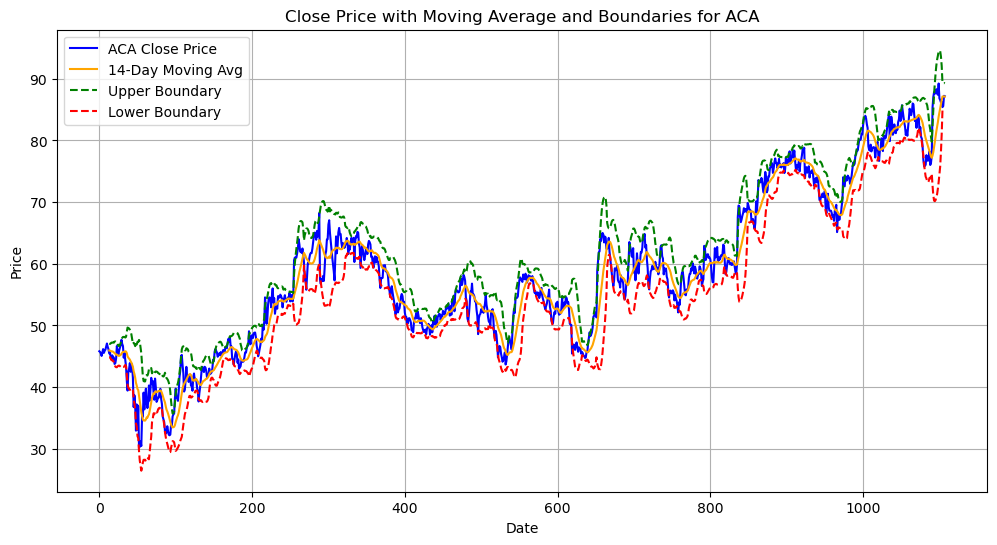

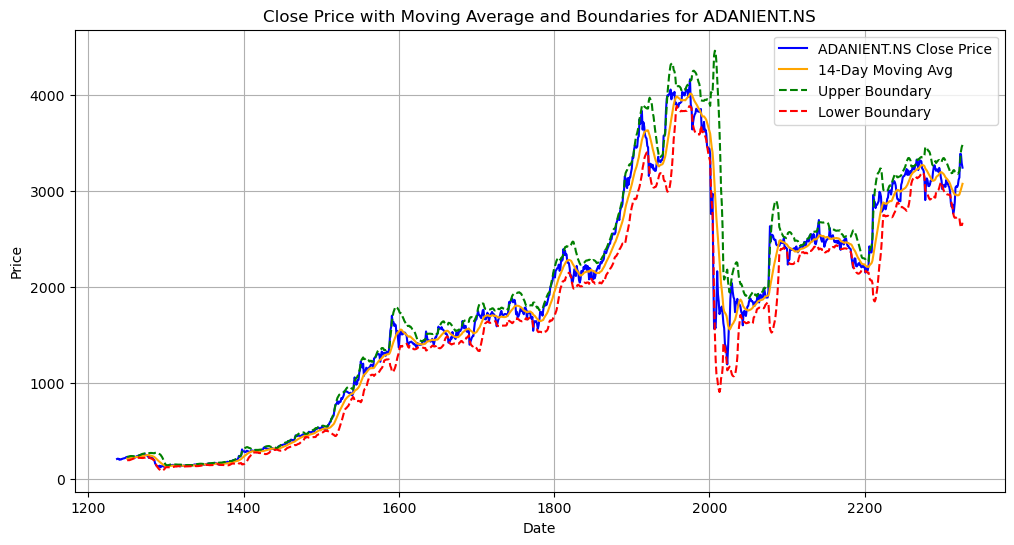

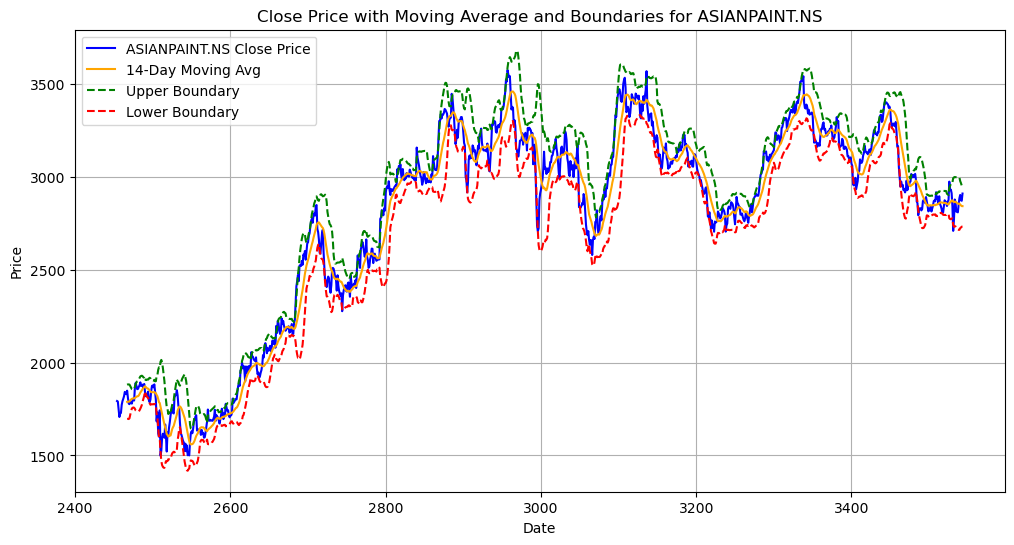

In [200]:
import matplotlib.pyplot as plt

# Iterate through the first three companies in the grouped dataset
for i, (company, group_data) in enumerate(grouped):
    if i == 3:  # Stop after plotting the first 3 companies
        break

    plt.figure(figsize=(12, 6))  # Create a new figure for each company

    # Plot the close price
    plt.plot(group_data.index, group_data['Close'], label=f"{company} Close Price", color='blue')

    # Plot the 14-day moving average
    plt.plot(group_data.index, group_data['Moving Average14'], label="14-Day Moving Avg", color='orange')

    # Plot the upper and lower Bollinger Bands (Boundaries)
    plt.plot(group_data.index, group_data['Upper Boundary14'], label="Upper Boundary", color='green', linestyle='--')
    plt.plot(group_data.index, group_data['Lower Boundary14'], label="Lower Boundary", color='red', linestyle='--')

    # Formatting the plot
    plt.title(f"Close Price with Moving Average and Boundaries for {company}")
    plt.xlabel("Date")
    plt.ylabel("Price")
    plt.legend()
    plt.grid(True)
    plt.show()


In [201]:

# Compute rolling mean, standard deviation, and volatility over different windows (e.g., 7, 14, 30 days)


df['Rolling_Mean_7'] = df['Adj Close'].rolling(window=7).mean()
df['Rolling_Std_7'] = df['Adj Close'].rolling(window=7).std()
df['Rolling_Mean_14'] = df['Adj Close'].rolling(window=14).mean()
df['Rolling_Std_14'] = df['Adj Close'].rolling(window=14).std()
df['Rolling_Mean_30'] = df['Adj Close'].rolling(window=30).mean()
df['Rolling_Std_30'] = df['Adj Close'].rolling(window=30).std()


# Lagged Features

In [202]:

# Include lagged values of Adj Close and Volume to capture short-term trends.

for lag in [1, 3, 5, 10]:
    df[f'Lag_{lag}'] = df['Adj Close'].shift(lag)

In [203]:
print(df.info())

<class 'pandas.core.frame.DataFrame'>
Index: 38684 entries, 0 to 43068
Columns: 112 entries, Date to Lag_10
dtypes: datetime64[ns](1), float64(101), int32(8), int64(1), object(1)
memory usage: 32.2+ MB
None


In [204]:
a=[]
for i in df.columns:
    a.append(i)
a

['Date',
 'Adj Close',
 'Close',
 'High',
 'Low',
 'Open',
 'Volume',
 'Company',
 'Target',
 'MFI',
 'OBV',
 'ADI',
 'CMF',
 'FI',
 'EMV',
 'VPT',
 'NVI',
 'VWAP',
 'Volume_5d_MA',
 'Volume_Buy_Signal',
 'BOP',
 'BB_MA20',
 'BB_std20',
 'BB_Upper',
 'BB_Lower',
 'BBW',
 'Prev_Close',
 'TR',
 'ATR',
 'KC_EMA20',
 'KC_Upper',
 'KC_Lower',
 'KCW',
 'DC_Upper',
 'DC_Lower',
 'DCW',
 'DCP',
 'UI',
 'NATR',
 'ADX',
 'WMA',
 'DEMA',
 'RSI',
 '%K',
 '%D',
 'ROC',
 'MOM',
 'Williams_%R',
 'CMO',
 'Aroon_Osc',
 'StochRSI',
 'HA_Close',
 'HA_Open',
 'HA_High',
 'HA_Low',
 'MA_7',
 'STD_7',
 'Upper_BB_7',
 'Lower_BB_7',
 'MA_14',
 'STD_14',
 'Upper_BB_14',
 'Lower_BB_14',
 'MA_30',
 'STD_30',
 'Upper_BB_30',
 'Lower_BB_30',
 'Log_Return',
 'EMA_12',
 'EMA_26',
 'EMA_30',
 'MACD',
 'Signal_Line',
 'RSI_14',
 '14_high',
 '14_low',
 '%R',
 'ROC_10',
 'Disparity_7',
 'Disparity_14',
 'Disparity_30',
 'Year',
 'Month',
 'Day',
 'DayOfWeek',
 'IsWeekend',
 'Company_Encoded',
 'Daily_Return',
 'Moving A

In [205]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 38684 entries, 0 to 43068
Columns: 112 entries, Date to Lag_10
dtypes: datetime64[ns](1), float64(101), int32(8), int64(1), object(1)
memory usage: 32.2+ MB


In [206]:
df=df.dropna()

In [207]:
df['Target'].value_counts()

Target
1    20088
0    13539
Name: count, dtype: int64

In [208]:
# df.to_csv(r"D:\idaieepapers\file.csv", index=False)


In [209]:
import numpy as np

# Select only numeric columns
numeric_df = df.select_dtypes(include=[np.number])

# Identify columns containing infinite values
infinite_columns = numeric_df.columns[numeric_df.apply(lambda x: np.isinf(x).any())].tolist()

# Print columns with infinite values if any
if infinite_columns:
    print("Columns with infinite values:")
    print(infinite_columns)
else:
    print("No infinite values found.")

# Double-check that no infinite values remain
print(np.any(np.isinf(numeric_df)))  


Columns with infinite values:
['ADI', 'VWAP']
True


In [1446]:
# above 2 columns are with infinite values so i removing those( difficulty while removing so)

In [210]:

X = df.drop(columns=['ADI', 'VWAP','Date','Target','Company'])
y = df['Target']

# feature selection 
# PCA

In [212]:

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, shuffle=False)


In [213]:

print(np.any(np.isnan(X_train)))  # Check for NaN values
print(np.any(np.isinf(X_train)))  # Check for infinite values

False
False


# NORMALISE

In [214]:

from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

X_train = scaler.fit_transform(X_train)

# Step 4: Transform the test data using the same scaler (don't fit again on test data)
X_test = scaler.transform(X_test)

**PCA** (apply)

In [216]:
from sklearn.decomposition import PCA
import numpy as np

# Step 1: Apply PCA
pca = PCA()
X_train_pca = pca.fit_transform(X_train)



In [217]:

# Step 2: Explained Variance Ratio
explained_variance_ratio = pca.explained_variance_ratio_
cumulative_variance = np.cumsum(explained_variance_ratio)


In [218]:
explained_variance_ratio

array([5.56990063e-01, 1.16430654e-01, 4.62360442e-02, 3.09651312e-02,
       2.88422820e-02, 1.82443412e-02, 1.56786387e-02, 1.33749506e-02,
       1.26064438e-02, 1.17333331e-02, 1.07700942e-02, 1.00906124e-02,
       9.85017158e-03, 9.36656460e-03, 9.33647166e-03, 8.95115249e-03,
       8.44334991e-03, 8.11594769e-03, 7.76946551e-03, 7.63495524e-03,
       7.27628470e-03, 6.98628679e-03, 5.70033075e-03, 5.19469997e-03,
       4.57008663e-03, 4.49496386e-03, 3.84509207e-03, 2.95715105e-03,
       2.81907626e-03, 2.47212403e-03, 2.26578753e-03, 2.08248831e-03,
       1.60647153e-03, 1.21626107e-03, 8.38433669e-04, 8.20136337e-04,
       6.80837461e-04, 5.95141244e-04, 5.40653629e-04, 4.65237632e-04,
       4.09736980e-04, 3.24115970e-04, 1.34563408e-04, 1.23880304e-04,
       8.24836966e-05, 2.08455614e-05, 1.45393864e-05, 7.29289360e-06,
       5.23330430e-06, 4.24824484e-06, 3.02894080e-06, 2.31166673e-06,
       2.23668277e-06, 1.47280448e-06, 1.23887033e-06, 9.60054532e-07,
      

In [219]:
cumulative_variance

array([0.55699006, 0.67342072, 0.71965676, 0.75062189, 0.77946417,
       0.79770852, 0.81338715, 0.82676211, 0.83936855, 0.85110188,
       0.86187198, 0.87196259, 0.88181276, 0.89117932, 0.9005158 ,
       0.90946695, 0.9179103 , 0.92602625, 0.93379571, 0.94143067,
       0.94870695, 0.95569324, 0.96139357, 0.96658827, 0.97115836,
       0.97565332, 0.97949841, 0.98245556, 0.98527464, 0.98774676,
       0.99001255, 0.99209504, 0.99370151, 0.99491777, 0.99575621,
       0.99657634, 0.99725718, 0.99785232, 0.99839297, 0.99885821,
       0.99926795, 0.99959206, 0.99972663, 0.99985051, 0.99993299,
       0.99995384, 0.99996838, 0.99997567, 0.9999809 , 0.99998515,
       0.99998818, 0.99999049, 0.99999273, 0.9999942 , 0.99999544,
       0.9999964 , 0.99999726, 0.99999799, 0.9999985 , 0.99999889,
       0.99999925, 0.9999995 , 0.99999965, 0.99999977, 0.99999985,
       0.9999999 , 0.99999994, 0.99999997, 0.99999998, 0.99999999,
       0.99999999, 1.        , 1.        , 1.        , 1.     

In [220]:

# Determine the number of components for 95% variance
n_components = np.argmax(cumulative_variance > 0.9487 ) + 1
print(f"Number of components to retain 094.87 % variance: {n_components}")


Number of components to retain 094.87 % variance: 21


In [221]:

# Step 3: Fit PCA with optimal number of components
pca_optimal = PCA(n_components=n_components)
X_train_pca_optimal = pca_optimal.fit_transform(X_train)
X_test_pca_optimal = pca_optimal.transform(X_test)


In [222]:

# Display PCA explained variance
for i, var in enumerate(explained_variance_ratio[:n_components]):
    print(f"PCA_{i+1}: {var:.4f} ({cumulative_variance[i]:.4f} cumulative variance)")

PCA_1: 0.5570 (0.5570 cumulative variance)
PCA_2: 0.1164 (0.6734 cumulative variance)
PCA_3: 0.0462 (0.7197 cumulative variance)
PCA_4: 0.0310 (0.7506 cumulative variance)
PCA_5: 0.0288 (0.7795 cumulative variance)
PCA_6: 0.0182 (0.7977 cumulative variance)
PCA_7: 0.0157 (0.8134 cumulative variance)
PCA_8: 0.0134 (0.8268 cumulative variance)
PCA_9: 0.0126 (0.8394 cumulative variance)
PCA_10: 0.0117 (0.8511 cumulative variance)
PCA_11: 0.0108 (0.8619 cumulative variance)
PCA_12: 0.0101 (0.8720 cumulative variance)
PCA_13: 0.0099 (0.8818 cumulative variance)
PCA_14: 0.0094 (0.8912 cumulative variance)
PCA_15: 0.0093 (0.9005 cumulative variance)
PCA_16: 0.0090 (0.9095 cumulative variance)
PCA_17: 0.0084 (0.9179 cumulative variance)
PCA_18: 0.0081 (0.9260 cumulative variance)
PCA_19: 0.0078 (0.9338 cumulative variance)
PCA_20: 0.0076 (0.9414 cumulative variance)
PCA_21: 0.0073 (0.9487 cumulative variance)


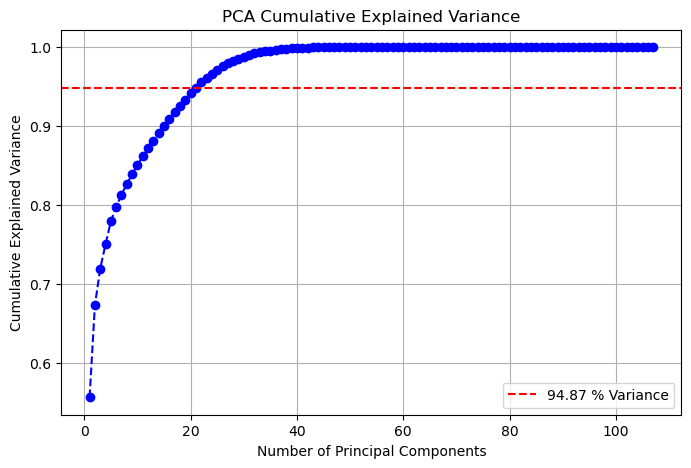

In [223]:

import matplotlib.pyplot as plt

# Plotting cumulative explained variance
plt.figure(figsize=(8, 5))
plt.plot(range(1, len(cumulative_variance) + 1), cumulative_variance, marker='o', linestyle='--', color='b')
plt.xlabel('Number of Principal Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('PCA Cumulative Explained Variance')
plt.grid(True)

# Mark the 95% threshold
plt.axhline(y=0.9487 , color='r', linestyle='--', label='94.87 % Variance')
plt.legend()
plt.show()


In [224]:
import pandas as pd
import numpy as np

# Original features
feature_names = X.columns

# PCA loadings (components)
loading_matrix = pca_optimal.components_

# Create a DataFrame for better visualization
loading_df = pd.DataFrame(loading_matrix.T, index=feature_names, columns=[f'PCA_{i+1}' for i in range(n_components)])

# Find the top contributing features for each component
top_features = {}
for i in range(n_components):
    top_features[f'PCA_{i+1}'] = loading_df[f'PCA_{i+1}'].sort_values(key=abs, ascending=False).head(5).index.tolist()

# Display top features for each component
for component, features in top_features.items():
    print(f"{component}: {features}")


PCA_1: ['BB_Upper', 'Upper Boundary30', 'Upper_BB_30', 'Upper_BB_14', 'Upper Boundary14']
PCA_2: ['Disparity_14', 'Williams_%R', '%K', '%R', 'DCP']
PCA_3: ['NATR', 'UI', 'BB_std20', 'BBW', 'STD_14']
PCA_4: ['Log Return', 'Log_Return', 'Daily_Return', 'FI', 'Disparity_7']
PCA_5: ['VPT', 'Volume_5d_MA', 'Volume', 'OBV', 'Company_Encoded']
PCA_6: ['MACD', 'Signal_Line', 'EMV', 'StochRSI', 'MOM']
PCA_7: ['RSI_14', 'MFI', 'Signal_Line', 'MACD', 'StochRSI']
PCA_8: ['EMV', 'UI', 'NATR', 'NVI', 'MOM']
PCA_9: ['Year', 'Month', 'CMF', 'ROC', 'ROC_10']
PCA_10: ['Year', 'Month', 'NVI', 'CMF', 'OBV']
PCA_11: ['Volume_Buy_Signal', 'CMF', 'NVI', 'Day', 'DayOfWeek']
PCA_12: ['DayOfWeek', 'Volume_Buy_Signal', 'CMF', 'IsWeekend', 'NVI']
PCA_13: ['IsWeekend', 'DayOfWeek', 'Day', 'Volume_Buy_Signal', 'NVI']
PCA_14: ['BOP', 'Day', 'IsWeekend', 'ADX', 'NVI']
PCA_15: ['ADX', 'IsWeekend', 'Day', 'Year', 'CMF']
PCA_16: ['Day', 'IsWeekend', 'DayOfWeek', 'ADX', 'BOP']
PCA_17: ['DayOfWeek', 'IsWeekend', 'Day', 'V

In [225]:
X.columns

Index(['Adj Close', 'Close', 'High', 'Low', 'Open', 'Volume', 'MFI', 'OBV',
       'CMF', 'FI',
       ...
       'Rolling_Mean_7', 'Rolling_Std_7', 'Rolling_Mean_14', 'Rolling_Std_14',
       'Rolling_Mean_30', 'Rolling_Std_30', 'Lag_1', 'Lag_3', 'Lag_5',
       'Lag_10'],
      dtype='object', length=107)

# MODELING
# LogisticRegression
# RandomForestClassifier
# XGBClassifier

In [311]:

import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, roc_auc_score

# RandomizedSearchCV is a technique used for hyperparameter tuning

In [313]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import uniform

# Parameter distributions for models (using distributions to sample randomly)
param_dist_lr = {
    'C': uniform(0.1, 10),  # Uniform distribution for C
    'penalty': ['l2'],
    'solver': ['liblinear']
}

param_dist_rf = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5, 10]
}

param_dist_xgb = {
    'n_estimators': [100, 200, 300],
    'learning_rate': uniform(0.01, 0.2),
    'max_depth': [3, 5, 7]
}

# Create RandomizedSearchCV for each model
rand_search_lr = RandomizedSearchCV(LogisticRegression(class_weight="balanced", random_state=42), param_dist_lr, n_iter=10, cv=5, n_jobs=-1, scoring='f1')
rand_search_rf = RandomizedSearchCV(RandomForestClassifier(class_weight="balanced", random_state=42), param_dist_rf, n_iter=10, cv=5, n_jobs=-1, scoring='f1')
rand_search_xgb = RandomizedSearchCV(XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42), param_dist_xgb, n_iter=10, cv=5, n_jobs=-1, scoring='f1')

# Fit randomized search
rand_search_lr.fit(X_train_pca_optimal, y_train)
rand_search_rf.fit(X_train_pca_optimal, y_train)
rand_search_xgb.fit(X_train_pca_optimal, y_train)


C:\Users\hp\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [21:57:48] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


RandomizedSearchCV(cv=5,
                   estimator=XGBClassifier(base_score=None, booster=None,
                                           callbacks=None,
                                           colsample_bylevel=None,
                                           colsample_bynode=None,
                                           colsample_bytree=None, device=None,
                                           early_stopping_rounds=None,
                                           enable_categorical=False,
                                           eval_metric='logloss',
                                           feature_types=None, gamma=None,
                                           grow_policy=None,
                                           importance_type=None,
                                           interaction_constraints=None,
                                           learning...
                                           max_leaves=None,
                                           min_child_weight=None, missing=nan,
                                           monotone_constraints=None,
                                           multi_strategy=None,
                                           n_estimators=None, n_jobs=None,
                                           num_parallel_tree=None,
                                           random_state=42, ...),
                   n_jobs=-1,
                   param_distributions={'learning_rate': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x0000023C323E7650>,
                                        'max_depth': [3, 5, 7],
                                        'n_estimators': [100, 200, 300]},
                   scoring='f1')

In [314]:

# Best parameters for each model
print("Best Parameters for Logistic Regression:", rand_search_lr.best_params_)
print("Best Parameters for Random Forest:", rand_search_rf.best_params_)
print("Best Parameters for XGBoost:", rand_search_xgb.best_params_)


Best Parameters for Logistic Regression: {'C': 0.24906244388258827, 'penalty': 'l2', 'solver': 'liblinear'}
Best Parameters for Random Forest: {'n_estimators': 300, 'min_samples_split': 5, 'max_depth': None}
Best Parameters for XGBoost: {'learning_rate': 0.10674657528813448, 'max_depth': 3, 'n_estimators': 100}


In [351]:

best_lr = LogisticRegression(class_weight="balanced", 
                              C=0.24906244388258827, 
                              penalty='l2', 
                              solver='liblinear', 
                              random_state=42)

best_rf = RandomForestClassifier(n_estimators=300, 
                                 min_samples_split=5, 
                                 max_depth=None, 
                                 class_weight="balanced", 
                                 random_state=42)

best_xgb = XGBClassifier(use_label_encoder=False, 
                         eval_metric='logloss', 
                         learning_rate=0.10674657528813448, 
                         max_depth=3, 
                         n_estimators=100, 
                         random_state=42)


In [353]:

# Dictionary with best models
best_models = {
    "Logistic Regression": best_lr,
    "Random Forest": best_rf,
    "XGBoost": best_xgb
}

def evaluate_model(y_true, y_pred, y_prob=None):
    cm = confusion_matrix(y_true, y_pred)
    tn, fp, fn, tp = cm.ravel()  # Extract true negatives, false positives, etc.
    
    metrics = {
        "Accuracy": accuracy_score(y_true, y_pred),
        "Precision": precision_score(y_true, y_pred, zero_division=0),
        "Recall (Sensitivity)": recall_score(y_true, y_pred, zero_division=0),
        "F1-Score": f1_score(y_true, y_pred, zero_division=0),
        "Specificity": tn / (tn + fp) if (tn + fp) > 0 else 0,
    }
    if y_prob is not None:
        metrics["ROC AUC"] = roc_auc_score(y_true, y_prob)
    return metrics

# Model training

In [357]:

# Train and evaluate the models with best parameters
results = {}
for name, model in best_models.items():
    # Train the model
    model.fit(X_train_pca_optimal, y_train)
    
    

C:\Users\hp\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [22:09:45] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


array([[-0.76938276, -0.77862881, -0.77948658, ..., -0.76741122,
        -0.7650444 , -0.76577467],
       [-0.76938276, -0.77862881, -0.77899975, ..., -0.7691011 ,
        -0.76564478, -0.76525456],
       [-0.7697908 , -0.77903914, -0.77929726, ..., -0.76836518,
        -0.76722761, -0.76571992],
       ...,
       [-0.80458256, -0.81344626, -0.81373815, ..., -0.80476673,
        -0.80584537, -0.80404675],
       [-0.80447579, -0.81333684, -0.81420876, ..., -0.80484695,
        -0.80492962, -0.80493846],
       [-0.80448647, -0.81334778, -0.81413844, ..., -0.80399653,
        -0.80462972, -0.80495994]])

In [361]:
#21 PCs
results_df = pd.DataFrame(results).T
results_df

,Accuracy,Precision,Recall (Sensitivity),F1-Score,Specificity,ROC AUC
Logistic Regression,0.433839,0.286822,0.063830,0.104421,0.830049,0.384139
Random Forest,0.336307,0.196054,0.091432,0.124706,0.598522,0.342179
XGBoost,0.531966,0.525518,0.976998,0.683427,0.055419,0.480632


In [297]:
# 110 PARA WITH 27 PCs (runned before)
results_df = pd.DataFrame(results).T
results_df

,Accuracy,Precision,Recall (Sensitivity),F1-Score,Specificity,ROC AUC
Logistic Regression,0.460601,0.330317,0.041978,0.074490,0.908867,0.377217
Random Forest,0.603628,0.597973,0.712478,0.650223,0.487069,0.617038
XGBoost,0.725840,0.701728,0.817136,0.755048,0.628079,0.816615


In [382]:
X_test

array([[-0.76938276, -0.77862881, -0.77948658, ..., -0.76741122,
        -0.7650444 , -0.76577467],
       [-0.76938276, -0.77862881, -0.77899975, ..., -0.7691011 ,
        -0.76564478, -0.76525456],
       [-0.7697908 , -0.77903914, -0.77929726, ..., -0.76836518,
        -0.76722761, -0.76571992],
       ...,
       [-0.80458256, -0.81344626, -0.81373815, ..., -0.80476673,
        -0.80584537, -0.80404675],
       [-0.80447579, -0.81333684, -0.81420876, ..., -0.80484695,
        -0.80492962, -0.80493846],
       [-0.80448647, -0.81334778, -0.81413844, ..., -0.80399653,
        -0.80462972, -0.80495994]])

In [131]:
from joblib import dump

# Save the dictionary of models
dump(best_models, "best_models.joblib")


NameError: name 'best_models' is not defined

# 
# **FINAL UNSEEN DATA TESTING** - LAST 6 MONTHS

In [1217]:

df=pd.read_csv(r"C:\Users\hp\IDA_Stock_project\data_set_ida\main_data\.ipynb_checkpoints\cleaned_stock_data_updated-checkpoint.csv")
df['Date'] = pd.to_datetime(df['Date'])
start_date = pd.to_datetime('2024-05-29')
end_date = pd.to_datetime('2024-11-29')

final_test_data= df[(df['Date'] >= start_date) & (df['Date'] <= end_date)]    #TEST

df = df[(df['Date'] < start_date)]    #training
data=df

In [1219]:
final_test_data

,Unnamed: 0,Date,Adj Close,Close,High,Low,Open,Volume,Company
1108,1108,2024-05-29,86.394798,86.489998,86.970001,85.809998,85.989998,182100,ACA
1109,1109,2024-05-30,88.342651,88.440002,88.519997,86.379997,86.800003,402500,ACA
1110,1110,2024-05-31,87.813240,87.910004,89.430000,86.970001,88.599998,428400,ACA
1111,1111,2024-06-03,86.105110,86.199997,88.809998,85.879997,88.389999,152400,ACA
1112,1112,2024-06-04,83.907539,84.000000,85.870003,83.230003,85.610001,171600,ACA
...,...,...,...,...,...,...,...,...,...
43191,43191,2024-11-25,291.225006,291.225006,293.774994,286.950012,287.750000,23297474,WIPRO.NS
43192,43192,2024-11-26,294.500000,294.500000,295.174988,289.649994,292.500000,15771340,WIPRO.NS
43193,43193,2024-11-27,291.450012,291.450012,298.000000,290.950012,295.750000,13659676,WIPRO.NS
43194,43194,2024-11-28,286.100006,286.100006,293.000000,285.274994,292.875000,11896556,WIPRO.NS


In [1220]:
del final_test_data['Unnamed: 0']

In [1221]:
df= final_test_data
df

,Date,Adj Close,Close,High,Low,Open,Volume,Company
1108,2024-05-29,86.394798,86.489998,86.970001,85.809998,85.989998,182100,ACA
1109,2024-05-30,88.342651,88.440002,88.519997,86.379997,86.800003,402500,ACA
1110,2024-05-31,87.813240,87.910004,89.430000,86.970001,88.599998,428400,ACA
1111,2024-06-03,86.105110,86.199997,88.809998,85.879997,88.389999,152400,ACA
1112,2024-06-04,83.907539,84.000000,85.870003,83.230003,85.610001,171600,ACA
...,...,...,...,...,...,...,...,...
43191,2024-11-25,291.225006,291.225006,293.774994,286.950012,287.750000,23297474,WIPRO.NS
43192,2024-11-26,294.500000,294.500000,295.174988,289.649994,292.500000,15771340,WIPRO.NS
43193,2024-11-27,291.450012,291.450012,298.000000,290.950012,295.750000,13659676,WIPRO.NS
43194,2024-11-28,286.100006,286.100006,293.000000,285.274994,292.875000,11896556,WIPRO.NS


In [1222]:


final_test_data['Target'] = (final_test_data['Adj Close'].shift(-30) > final_test_data['Adj Close']).astype(int)
final_test_data['Target'].value_counts()

Target
1    2491
0    2021
Name: count, dtype: int64

<Axes: xlabel='Target'>

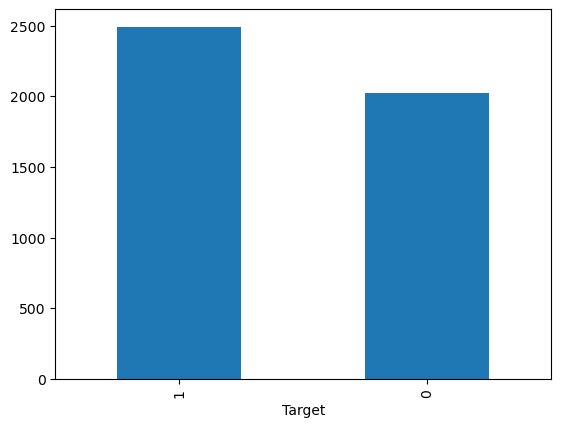

In [1460]:
final_test_data['Target'].value_counts().plot(kind='bar')

# **APPLYING ALL FEATURES WHICH DONE ON  TRAINING DATA**

In [1223]:
# Money Flow Index (MFI)
def compute_mfi(group, window=14):
    typical_price = (group['High'] + group['Low'] + group['Close']) / 3
    money_flow = typical_price * group['Volume']
    positive_flow = (typical_price > typical_price.shift(1)) * money_flow
    negative_flow = (typical_price < typical_price.shift(1)) * money_flow
    positive_flow_sum = positive_flow.rolling(window).sum()
    negative_flow_sum = negative_flow.rolling(window).sum()
    mfi = 100 - 100 / (1 + (positive_flow_sum / negative_flow_sum).replace(0, 1e-5))
    return mfi

df['MFI'] = df.groupby('Company', group_keys=False).apply(compute_mfi)

# On-Balance Volume (OBV)
def compute_obv(group):
    obv = (group['Volume'] * np.sign(group['Close'].diff())).cumsum()
    return obv

df['OBV'] = df.groupby('Company', group_keys=False).apply(compute_obv)

# Accumulation/Distribution Index (ADI)
def compute_adi(group):
    clv = ((group['Close'] - group['Low']) - (group['High'] - group['Close'])) / (group['High'] - group['Low']).replace(0, 1e-5)
    adi = (clv * group['Volume']).cumsum()
    return adi

df['ADI'] = df.groupby('Company', group_keys=False).apply(compute_adi)

# Chaikin Money Flow (CMF)
def compute_cmf(group, window=20):
    ad_line = compute_adi(group)  # Reuse ADI calculation
    cmf = ad_line.rolling(window).mean()  # Or use volume-based calculation
    return cmf

df['CMF'] = df.groupby('Company', group_keys=False).apply(compute_cmf)

# Force Index (FI)
df['FI'] = df.groupby('Company')['Close'].transform(lambda x: x.diff()) * df['Volume']

# Ease of Movement (EMV)
def compute_emv(group, window=14):
    midpoint_diff = (group['High'] + group['Low']).diff() / 2
    volume_adj = (group['Volume'] / 1e8) / (group['High'] - group['Low'])
    emv = (midpoint_diff / volume_adj).rolling(window).mean()
    return emv

df['EMV'] = df.groupby('Company', group_keys=False).apply(compute_emv)

# Volume-Price Trend (VPT)
df['VPT'] = df.groupby('Company', group_keys=False)['Close'].pct_change().add(1).cumprod() * df['Volume']

# Negative Volume Index (NVI)
def compute_nvi(group):
    nvi = (group['Close'].pct_change() * (group['Volume'] < group['Volume'].shift())).add(1).cumprod() * 1000
    return nvi

df['NVI'] = df.groupby('Company', group_keys=False).apply(compute_nvi)

# Volume Weighted Average Price (VWAP)
df['VWAP'] = df.groupby('Company', group_keys=False).apply(lambda x: (x['Close'] * x['Volume']).cumsum() / x['Volume'].cumsum())

# Price Volume Analysis (5-day MA)
df['Volume_5d_MA'] = df.groupby('Company')['Volume'].transform(lambda x: x.rolling(5).mean())
df['Volume_Buy_Signal'] = (df['Volume'] > df['Volume_5d_MA']).astype(int)

# Balance of Power (BOP)
df['BOP'] = (df['Close'] - df['Open']) / (df['High'] - df['Low']).replace(0, 1e-5)

C:\Users\hp\AppData\Local\Temp\ipykernel_9264\83885882.py:12: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df['MFI'] = df.groupby('Company', group_keys=False).apply(compute_mfi)
C:\Users\hp\AppData\Local\Temp\ipykernel_9264\83885882.py:19: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df['OBV'] = df.groupby('Company', group_keys=False).apply(compute_obv)
C:\Users\hp\AppData\Local\Temp\ipykernel_9264\838858

In [1224]:
# Bollinger Bands (20-period)
df['BB_MA20'] = df.groupby('Company')['Close'].transform(lambda x: x.rolling(20).mean())
df['BB_std20'] = df.groupby('Company')['Close'].transform(lambda x: x.rolling(20).std())
df['BB_Upper'] = df['BB_MA20'] + 2 * df['BB_std20']
df['BB_Lower'] = df['BB_MA20'] - 2 * df['BB_std20']
df['BBW'] = df['BB_Upper'] - df['BB_Lower']

# Keltner Channel
# Calculate True Range (TR)

df['Prev_Close'] = df['Close'].shift(1)

df['TR'] = df.apply(
    lambda x: max(
        x['High'] - x['Low'],
        abs(x['High'] - x['Prev_Close']),
        abs(x['Low'] - x['Prev_Close'])
    ), axis=1
)

# Calculate ATR (14-period rolling average of TR)
df['ATR'] = df.groupby('Company')['TR'].transform(lambda x: x.rolling(window=14).mean())

df['KC_EMA20'] = df.groupby('Company')['Close'].transform(lambda x: x.ewm(span=20, adjust=False).mean())
df['KC_Upper'] = df['KC_EMA20'] + 2 * df['ATR']
df['KC_Lower'] = df['KC_EMA20'] - 2 * df['ATR']
df['KCW'] = df['KC_Upper'] - df['KC_Lower']

# Donchian Channel
df['DC_Upper'] = df.groupby('Company')['High'].transform(lambda x: x.rolling(20).max())
df['DC_Lower'] = df.groupby('Company')['Low'].transform(lambda x: x.rolling(20).min())
df['DCW'] = df['DC_Upper'] - df['DC_Lower']
df['DCP'] = (df['Close'] - df['DC_Lower']) / (df['DC_Upper'] - df['DC_Lower']).replace(0, 1e-5)

# Ulcer Index
def compute_ui(group, window=14):
    max_close = group['Close'].rolling(window).max()
    drawdown = (group['Close'] - max_close) / max_close
    ui = np.sqrt((drawdown**2).rolling(window).mean())
    return ui

df['UI'] = df.groupby('Company', group_keys=False).apply(compute_ui)

# Normalized ATR
df['NATR'] = (df['ATR'] / df['Close']) * 100

C:\Users\hp\AppData\Local\Temp\ipykernel_9264\381824765.py:42: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df['UI'] = df.groupby('Company', group_keys=False).apply(compute_ui)


In [1225]:
import numpy as np
import pandas as pd

def compute_adx(group, window=14):
    prev_close = group['Close'].shift()
    tr = np.maximum.reduce([
        group['High'] - group['Low'],
        abs(group['High'] - prev_close),
        abs(group['Low'] - prev_close)
    ])
    
    plus_dm = np.where((group['High'].diff() > group['Low'].diff()), group['High'].diff(), 0)
    minus_dm = np.where((group['Low'].diff() > group['High'].diff()), group['Low'].diff(), 0)

    tr_ema = pd.Series(tr, index=group.index).ewm(span=window, adjust=False).mean()
    plus_di = 100 * (pd.Series(plus_dm, index=group.index).ewm(span=window, adjust=False).mean() / tr_ema)
    minus_di = 100 * (pd.Series(minus_dm, index=group.index).ewm(span=window, adjust=False).mean() / tr_ema)

    dx = 100 * abs(plus_di - minus_di) / (plus_di + minus_di)
    adx = dx.ewm(span=window, adjust=False).mean()

    return pd.Series(adx, index=group.index)

df['ADX'] = df.groupby('Company', group_keys=False).apply(compute_adx)


C:\Users\hp\AppData\Local\Temp\ipykernel_9264\76432221.py:24: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df['ADX'] = df.groupby('Company', group_keys=False).apply(compute_adx)


In [1226]:

# Weighted Moving Average (WMA)
def compute_wma(group, window=14):
    weights = np.arange(1, window+1)
    return group['Close'].rolling(window).apply(lambda x: np.dot(x, weights)/weights.sum(), raw=True)

df['WMA'] = df.groupby('Company', group_keys=False).apply(compute_wma)

# DEMA
def compute_dema(group, window=14):
    ema = group['Close'].ewm(span=window, adjust=False).mean()
    dema = 2 * ema - ema.ewm(span=window, adjust=False).mean()
    return dema

df['DEMA'] = df.groupby('Company', group_keys=False).apply(compute_dema)

C:\Users\hp\AppData\Local\Temp\ipykernel_9264\3461525333.py:6: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df['WMA'] = df.groupby('Company', group_keys=False).apply(compute_wma)
C:\Users\hp\AppData\Local\Temp\ipykernel_9264\3461525333.py:14: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df['DEMA'] = df.groupby('Company', group_keys=False).apply(compute_dema)


In [1227]:
import numpy as np
import pandas as pd

# Relative Strength Index (RSI)
def compute_rsi(group, window=14):
    delta = group['Close'].diff()
    gain = (delta.where(delta > 0, 0)).rolling(window=window).mean()
    loss = (-delta.where(delta < 0, 0)).rolling(window=window).mean()
    rs = gain / loss
    rsi = 100 - (100 / (1 + rs))
    return rsi

df['RSI'] = df.groupby('Company', group_keys=False).apply(compute_rsi)

# Stochastic Oscillator (%K and %D)
def compute_stochastic(group, window=14):
    low_min = group['Low'].rolling(window=window).min()
    high_max = group['High'].rolling(window=window).max()
    group['%K'] = (group['Close'] - low_min) / (high_max - low_min) * 100
    group['%D'] = group['%K'].rolling(window=3).mean()
    return group[['%K', '%D']]

stochastic_data = df.groupby('Company', group_keys=False).apply(compute_stochastic)
df = df.join(stochastic_data)

# Rate of Change (ROC)
df['ROC'] = df.groupby('Company')['Close'].transform(lambda x: x.pct_change(periods=10) * 100)

# Momentum (MOM)
df['MOM'] = df.groupby('Company')['Close'].transform(lambda x: x.diff(periods=10))

# Williams %R
def compute_williams_r(group, window=14):
    high_max = group['High'].rolling(window=window).max()
    low_min = group['Low'].rolling(window=window).min()
    williams_r = (high_max - group['Close']) / (high_max - low_min) * -100
    return williams_r

df['Williams_%R'] = df.groupby('Company', group_keys=False).apply(compute_williams_r)

# Chande Momentum Oscillator (CMO)
def compute_cmo(group, window=14):
    delta = group['Close'].diff()
    gain = delta.where(delta > 0, 0)
    loss = -delta.where(delta < 0, 0)
    cmo = 100 * (gain.rolling(window=window).sum() - loss.rolling(window=window).sum()) / (gain.rolling(window=window).sum() + loss.rolling(window=window).sum())
    return cmo

df['CMO'] = df.groupby('Company', group_keys=False).apply(compute_cmo)

# Aroon Oscillator
def compute_aroon(group, window=14):
    aroon_up = 100 * (window - group['High'].rolling(window=window).apply(lambda x: x.argmax())) / window
    aroon_down = 100 * (window - group['Low'].rolling(window=window).apply(lambda x: x.argmin())) / window
    aroon_osc = aroon_up - aroon_down
    return aroon_osc

df['Aroon_Osc'] = df.groupby('Company', group_keys=False).apply(compute_aroon)

# Stochastic RSI
def compute_stoch_rsi(group, window=14):
    rsi = compute_rsi(group, window)
    stoch_k = (rsi - rsi.rolling(window=window).min()) / (rsi.rolling(window=window).max() - rsi.rolling(window=window).min()) * 100
    return stoch_k

df['StochRSI'] = df.groupby('Company', group_keys=False).apply(compute_stoch_rsi)

C:\Users\hp\AppData\Local\Temp\ipykernel_9264\2013637963.py:13: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df['RSI'] = df.groupby('Company', group_keys=False).apply(compute_rsi)
C:\Users\hp\AppData\Local\Temp\ipykernel_9264\2013637963.py:23: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  stochastic_data = df.groupby('Company', group_keys=False).apply(compute_stochastic)
C:\Users\hp\AppData\Local\Temp\ipyk

In [1228]:
def compute_ha(group):
    ha_close = (group['Open'] + group['High'] + group['Low'] + group['Close']) / 4
    ha_open = (group['Open'].shift() + group['Close'].shift()) / 2

    ha_high = pd.concat([group['High'], ha_open, ha_close], axis=1).max(axis=1)
    ha_low = pd.concat([group['Low'], ha_open, ha_close], axis=1).min(axis=1)

    return pd.DataFrame({'HA_Close': ha_close, 'HA_Open': ha_open, 'HA_High': ha_high, 'HA_Low': ha_low}, index=group.index)

ha_data = df.groupby('Company', group_keys=False).apply(compute_ha)
df = df.join(ha_data)


C:\Users\hp\AppData\Local\Temp\ipykernel_9264\608078162.py:10: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  ha_data = df.groupby('Company', group_keys=False).apply(compute_ha)


In [1229]:
import numpy as np
import pandas as pd

# Load dataset and preprocess
df['Date'] = pd.to_datetime(df['Date'])
df = df.sort_values(['Company', 'Date'])
grouped = df.groupby('Company', group_keys=False)

# Moving Averages & Bollinger Bands
std_multiplier = 2
for window in [7, 14, 30]:
    df[f'MA_{window}'] = grouped['Close'].transform(lambda x: x.rolling(window).mean())
    df[f'STD_{window}'] = grouped['Close'].transform(lambda x: x.rolling(window).std())
    df[f'Upper_BB_{window}'] = df[f'MA_{window}'] + std_multiplier * df[f'STD_{window}']
    df[f'Lower_BB_{window}'] = df[f'MA_{window}'] - std_multiplier * df[f'STD_{window}']

# Log Return
df['Log_Return'] = np.log(df['Close'] / df['Close'].shift(1))

# Exponential Moving Averages
df['EMA_12'] = df['Close'].ewm(span=12, adjust=False).mean()
df['EMA_26'] = df['Close'].ewm(span=26, adjust=False).mean()
df['EMA_30'] = df['Close'].ewm(span=30, adjust=False).mean()

# MACD and Signal Line
df['MACD'] = df['EMA_12'] - df['EMA_26']
df['Signal_Line'] = df['MACD'].ewm(span=9, adjust=False).mean()

# RSI Calculation
def compute_rsi(data, window=14):
    delta = data.diff()
    gain = np.where(delta > 0, delta, 0)
    loss = np.where(delta < 0, -delta, 0)
    avg_gain = pd.Series(gain).rolling(window).mean()
    avg_loss = pd.Series(loss).rolling(window).mean()
    rs = avg_gain / avg_loss
    return 100 - (100 / (1 + rs))

df['RSI_14'] = compute_rsi(df['Close'])

# Stochastic Oscillator
df['14_high'] = df['High'].rolling(14).max()
df['14_low'] = df['Low'].rolling(14).min()
df['%K'] = (df['Close'] - df['14_low']) / (df['14_high'] - df['14_low']) * 100
df['%D'] = df['%K'].rolling(window=3).mean()

# Williams %R
df['%R'] = (df['14_high'] - df['Close']) / (df['14_high'] - df['14_low']) * -100

# Rate of Change (ROC)
df['ROC_10'] = df['Close'].pct_change(periods=10) * 100

# True Range & ATR
df['TR'] = np.maximum(df['High'] - df['Low'], np.maximum(abs(df['High'] - df['Close'].shift(1)), abs(df['Low'] - df['Close'].shift(1))))
df['ATR'] = df['TR'].rolling(window=14).mean()

# Disparity Index
for window in [7, 14, 30]:
    df[f'Disparity_{window}'] = (df['Close'] / df[f'MA_{window}'] - 1) * 100

# Date Features
df['Year'] = df['Date'].dt.year
df['Month'] = df['Date'].dt.month
df['Day'] = df['Date'].dt.day
df['DayOfWeek'] = df['Date'].dt.dayofweek
df['IsWeekend'] = (df['DayOfWeek'] >= 5).astype(int)

# Money Flow Index (MFI)
def calculate_mfi(df, window=14):
    typical_price = (df['High'] + df['Low'] + df['Close']) / 3
    money_flow = typical_price * df['Volume']
    positive_flow = money_flow.where(typical_price > typical_price.shift(1), 0)
    negative_flow = money_flow.where(typical_price < typical_price.shift(1), 0)
    positive_sum = positive_flow.rolling(window).sum()
    negative_sum = negative_flow.rolling(window).sum()
    return 100 - (100 / (1 + (positive_sum / negative_sum)))

df['MFI'] = grouped.apply(lambda x: calculate_mfi(x)).reset_index(level=0, drop=True)

# Accumulation/Distribution Index (ADI)
df['MF_Multiplier'] = ((df['Close'] - df['Low']) - (df['High'] - df['Close'])) / (df['High'] - df['Low'])
df['MF_Volume'] = df['MF_Multiplier'] * df['Volume']
df['ADI'] = grouped['MF_Volume'].cumsum()

# Volume Weighted Average Price (VWAP)
df['Cumulative_PV'] = grouped.apply(lambda x: (x['Close'] * x['Volume']).cumsum()).reset_index(level=0, drop=True)
df['Cumulative_Volume'] = grouped['Volume'].cumsum()
df['VWAP'] = df['Cumulative_PV'] / df['Cumulative_Volume']

# Keltner Channels
df['KC_Upper'] = df['EMA_30'] + 2 * df['ATR']
df['KC_Lower'] = df['EMA_30'] - 2 * df['ATR']

# Donchian Channels
df['DC_Upper'] = grouped['High'].transform(lambda x: x.rolling(20).max())
df['DC_Lower'] = grouped['Low'].transform(lambda x: x.rolling(20).min())

# Fill missing values
df.fillna(method='bfill', inplace=True)

df.drop(columns=['MF_Multiplier', 'MF_Volume', 'Cumulative_PV', 'Cumulative_Volume'], inplace=True)

print("Technical indicators successfully added!")


Technical indicators successfully added!


C:\Users\hp\AppData\Local\Temp\ipykernel_9264\3603219289.py:78: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df['MFI'] = grouped.apply(lambda x: calculate_mfi(x)).reset_index(level=0, drop=True)
C:\Users\hp\AppData\Local\Temp\ipykernel_9264\3603219289.py:86: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df['Cumulative_PV'] = grouped.apply(lambda x: (x['Close'] * x['Volume']).cumsum()).reset_index(level=0, 

In [1230]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
df['Company_Encoded'] = le.fit_transform(df['Company'])


In [1231]:
df['Daily_Return'] = df['Adj Close'].pct_change()


In [1232]:
grouped = df.groupby('Company')

In [1233]:
# Add Moving Average, Upper, and Lower Boundaries
std_multiplier=2
df['Moving Average7'] = grouped['Close'].transform(lambda x: x.rolling(window=7).mean())
df['Rolling Std7'] = grouped['Close'].transform(lambda x: x.rolling(window=7).std())
df['Upper Boundary7'] = df['Moving Average7'] + (std_multiplier * df['Rolling Std7'])
df['Lower Boundary7'] = df['Moving Average7'] - (std_multiplier * df['Rolling Std7'])

df['Moving Average14'] = grouped['Close'].transform(lambda x: x.rolling(window=14).mean())
df['Rolling Std14'] = grouped['Close'].transform(lambda x: x.rolling(window=14).std())
df['Upper Boundary14'] = df['Moving Average14'] + (std_multiplier * df['Rolling Std14'])
df['Lower Boundary14'] = df['Moving Average14'] - (std_multiplier * df['Rolling Std14'])


df['Moving Average30'] = grouped['Close'].transform(lambda x: x.rolling(window=30).mean())
df['Rolling Std30'] = grouped['Close'].transform(lambda x: x.rolling(window=30).std())
df['Upper Boundary30'] = df['Moving Average30'] + (std_multiplier * df['Rolling Std30'])
df['Lower Boundary30'] = df['Moving Average30'] - (std_multiplier * df['Rolling Std30'])




df['Log Return'] = np.log(df['Close'] / df['Close'].shift(1))
df['Moving Average Log Return5'] = grouped['Log Return'].transform(lambda x: x.rolling(window=5).mean())
df['EMA_30'] = grouped['Close'].transform(lambda x: x.ewm(span=30, adjust=False).mean())


In [1234]:

df['Rolling_Mean_7'] = df['Adj Close'].rolling(window=7).mean()
df['Rolling_Std_7'] = df['Adj Close'].rolling(window=7).std()
df['Rolling_Mean_14'] = df['Adj Close'].rolling(window=14).mean()
df['Rolling_Std_14'] = df['Adj Close'].rolling(window=14).std()
df['Rolling_Mean_30'] = df['Adj Close'].rolling(window=30).mean()
df['Rolling_Std_30'] = df['Adj Close'].rolling(window=30).std()


In [1235]:
# Lagged Features
# Include lagged values of Adj Close and Volume to capture short-term trends.

for lag in [1, 3, 5, 10]:
    df[f'Lag_{lag}'] = df['Adj Close'].shift(lag)

In [1236]:
df2=df #REFERENCE SAVE

In [1378]:
df=df2

In [1380]:
# df=df.dropna()
df.isnull().sum()

Date               0
Adj Close          0
Close              0
High               0
Low                0
                  ..
Rolling_Std_30    29
Lag_1              1
Lag_3              3
Lag_5              5
Lag_10            10
Length: 112, dtype: int64

In [1382]:
df['Target'].value_counts()

Target
1    2491
0    2021
Name: count, dtype: int64

In [1384]:
# df=df.dropna()

In [1386]:

# Keep a copy of the columns you need for evaluation

df_eval = df[['Company', 'Target']]


In [1388]:
df

,Date,Adj Close,Close,High,Low,Open,Volume,Company,Target,MFI,...,Rolling_Mean_7,Rolling_Std_7,Rolling_Mean_14,Rolling_Std_14,Rolling_Mean_30,Rolling_Std_30,Lag_1,Lag_3,Lag_5,Lag_10
1108,2024-05-29,86.394798,86.489998,86.970001,85.809998,85.989998,182100,ACA,1,43.599234,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1109,2024-05-30,88.342651,88.440002,88.519997,86.379997,86.800003,402500,ACA,0,49.711485,...,NaN,NaN,NaN,NaN,NaN,NaN,86.394798,NaN,NaN,NaN
1110,2024-05-31,87.813240,87.910004,89.430000,86.970001,88.599998,428400,ACA,1,49.411876,...,NaN,NaN,NaN,NaN,NaN,NaN,88.342651,NaN,NaN,NaN
1111,2024-06-03,86.105110,86.199997,88.809998,85.879997,88.389999,152400,ACA,1,46.640041,...,NaN,NaN,NaN,NaN,NaN,NaN,87.813240,86.394798,NaN,NaN
1112,2024-06-04,83.907539,84.000000,85.870003,83.230003,85.610001,171600,ACA,1,53.191053,...,NaN,NaN,NaN,NaN,NaN,NaN,86.105110,88.342651,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
43191,2024-11-25,291.225006,291.225006,293.774994,286.950012,287.750000,23297474,WIPRO.NS,0,NaN,...,282.985718,4.912803,281.669647,5.735387,277.123336,7.034093,285.825012,281.000000,283.350006,281.700012
43192,2024-11-26,294.500000,294.500000,295.174988,289.649994,292.500000,15771340,WIPRO.NS,0,NaN,...,284.414289,6.593099,283.391076,5.709352,278.135003,7.282033,291.225006,278.575012,276.424988,284.500000
43193,2024-11-27,291.450012,291.450012,298.000000,290.950012,295.750000,13659676,WIPRO.NS,0,NaN,...,285.571433,7.068823,284.791077,5.023538,278.690837,7.644118,294.500000,285.825012,281.000000,286.750000
43194,2024-11-28,286.100006,286.100006,293.000000,285.274994,292.875000,11896556,WIPRO.NS,0,NaN,...,286.953578,5.817491,285.087505,4.965099,279.345003,7.398450,291.450012,291.225006,278.575012,285.325012


In [1391]:
df['Target'].value_counts()

Target
1    2491
0    2021
Name: count, dtype: int64

In [1393]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 4512 entries, 1108 to 43195
Columns: 112 entries, Date to Lag_10
dtypes: datetime64[ns](1), float64(101), int32(8), int64(1), object(1)
memory usage: 3.8+ MB


In [1397]:
del df['Date']


In [1395]:
del df['Company']

# Handling null

In [1399]:
# X.interpolate(method='linear', inplace=True)  # Linear interpolation
# X.interpolate(method='polynomial', order=2, inplace=True)  # Polynomial (2nd order)
# X.interpolate(method='spline', order=3, inplace=True)  # Spline for smoother fit
 from sklearn.impute import KNNImputer

knn_imputer = KNNImputer(n_neighbors=2, weights="distance")  # Use 2 closest neighbors
df_imputed = knn_imputer.fit_transform(df)  # Returns NumPy array
df = pd.DataFrame(df_imputed, columns=df.columns)  # Convert back to DataFrame



In [1401]:
df.isnull().sum()

Adj Close         0
Close             0
High              0
Low               0
Open              0
                 ..
Rolling_Std_30    0
Lag_1             0
Lag_3             0
Lag_5             0
Lag_10            0
Length: 110, dtype: int64

In [1403]:
X=df

In [1405]:
X['Target'].value_counts().sum()

4512

In [1407]:
# X.fillna(X.mean(), inplace=True)  # Mean imputation

X.isnull().sum()

Adj Close         0
Close             0
High              0
Low               0
Open              0
                 ..
Rolling_Std_30    0
Lag_1             0
Lag_3             0
Lag_5             0
Lag_10            0
Length: 110, dtype: int64

In [1307]:
print(X.shape)  # Original data shape


(296, 112)


In [1409]:
X

,Adj Close,Close,High,Low,Open,Volume,Target,MFI,OBV,ADI,...,Rolling_Mean_7,Rolling_Std_7,Rolling_Mean_14,Rolling_Std_14,Rolling_Mean_30,Rolling_Std_30,Lag_1,Lag_3,Lag_5,Lag_10
0,86.394798,86.489998,86.970001,85.809998,85.989998,182100.0,1.0,43.599234,402500.0,3.139597e+04,...,47.784783,0.939275,49.077325,2.379732,49.870929,3.218951,46.688605,47.297760,47.563890,49.816151
1,88.342651,88.440002,88.519997,86.379997,86.800003,402500.0,0.0,49.711485,402500.0,4.038047e+05,...,87.281596,4.972377,86.766341,4.900942,85.154709,4.043297,86.394798,90.307954,89.919411,87.158654
2,87.813240,87.910004,89.430000,86.970001,88.599998,428400.0,1.0,49.411876,-25900.0,3.028008e+05,...,50.068035,1.213891,49.176738,3.849266,51.172177,3.894348,88.342651,52.202111,49.157503,46.732966
3,86.105110,86.199997,88.809998,85.879997,88.389999,152400.0,1.0,46.640041,-178300.0,1.836895e+05,...,85.963335,1.699207,18.690532,4.932219,21.924799,4.530566,87.813240,86.394798,88.112456,58.633864
4,83.907539,84.000000,85.870003,83.230003,85.610001,171600.0,1.0,53.191053,-349900.0,1.121891e+05,...,85.928967,1.721870,82.904500,1.152142,21.930652,4.527722,86.105110,88.342651,88.067874,86.153311
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4507,291.225006,291.225006,293.774994,286.950012,287.750000,23297474.0,0.0,53.927037,389005454.0,-2.952205e+07,...,282.985718,4.912803,281.669647,5.735387,277.123336,7.034093,285.825012,281.000000,283.350006,281.700012
4508,294.500000,294.500000,295.174988,289.649994,292.500000,15771340.0,0.0,47.170165,404776794.0,-1.760427e+07,...,284.414289,6.593099,283.391076,5.709352,278.135003,7.282033,291.225006,278.575012,276.424988,284.500000
4509,291.450012,291.450012,298.000000,290.950012,295.750000,13659676.0,0.0,37.665938,391117118.0,-2.932640e+07,...,285.571433,7.068823,284.791077,5.023538,278.690837,7.644118,294.500000,285.825012,281.000000,286.750000
4510,286.100006,286.100006,293.000000,285.274994,292.875000,11896556.0,0.0,37.674836,379220562.0,-3.868191e+07,...,286.953578,5.817491,285.087505,4.965099,279.345003,7.398450,291.450012,291.225006,278.575012,285.325012


In [1411]:
y = X['Target']
X = X.drop(columns=['ADI' ,'VWAP','Target'])


# PCA ON FINAL TEST DATA

In [1414]:

X_test = scaler.transform(X)

In [1415]:

X_test_pca = pca.transform(X_test)



In [1416]:
X_test_pca_optimal = pca_optimal.transform(X_test_pca)


In [1417]:
from joblib import load

# Load the models
loaded_models = load("best_models.joblib")


In [1418]:

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, roc_auc_score

# Define a function to evaluate the models
def evaluate_model(y_true, y_pred, y_prob=None):
    cm = confusion_matrix(y_true, y_pred)
    tn, fp, fn, tp = cm.ravel()  # Extract true negatives, false positives, etc.
    
    metrics = {
        "Accuracy": accuracy_score(y_true, y_pred),
        "Precision": precision_score(y_true, y_pred, zero_division=0),
        "Recall (Sensitivity)": recall_score(y_true, y_pred, zero_division=0),
        "F1-Score": f1_score(y_true, y_pred, zero_division=0),
        "Specificity": tn / (tn + fp) if (tn + fp) > 0 else 0,
    }
    if y_prob is not None:
        metrics["ROC AUC"] = roc_auc_score(y_true, y_prob)
    return metrics

# Initialize a dictionary to store results
results = {}


# TESTING 

In [1419]:

# Predict and evaluate for each model
for name, model in loaded_models.items():
    print(f"Evaluating {name} model...")
    
    # Predict on the test data
    y_pred = model.predict(X_test_pca_optimal)
    
    # If the model supports probability predictions, get probabilities
    y_prob = model.predict_proba(X_test_pca_optimal)[:, 1] if hasattr(model, "predict_proba") else None
    
    # Evaluate the model
    results[name] = evaluate_model(y, y_pred, y_prob)
    

Evaluating Logistic Regression model...
Evaluating Random Forest model...
Evaluating XGBoost model...


# TEST SCORES

In [1420]:

# Print results for each model
for model_name, metrics in results.items():
    print(f"Results for {model_name}:")
    for metric, value in metrics.items():
        print(f"  {metric}: {value:.4f}")
    print("-" * 40)


Results for Logistic Regression:
  Accuracy: 0.5075
  Precision: 0.5728
  Recall (Sensitivity): 0.4247
  F1-Score: 0.4878
  Specificity: 0.6096
  ROC AUC: 0.5118
----------------------------------------
Results for Random Forest:
  Accuracy: 0.5521
  Precision: 0.5526
  Recall (Sensitivity): 0.9912
  F1-Score: 0.7096
  Specificity: 0.0109
  ROC AUC: 0.5285
----------------------------------------
Results for XGBoost:
  Accuracy: 0.5545
  Precision: 0.5536
  Recall (Sensitivity): 0.9976
  F1-Score: 0.7120
  Specificity: 0.0084
  ROC AUC: 0.5740
----------------------------------------


# curves

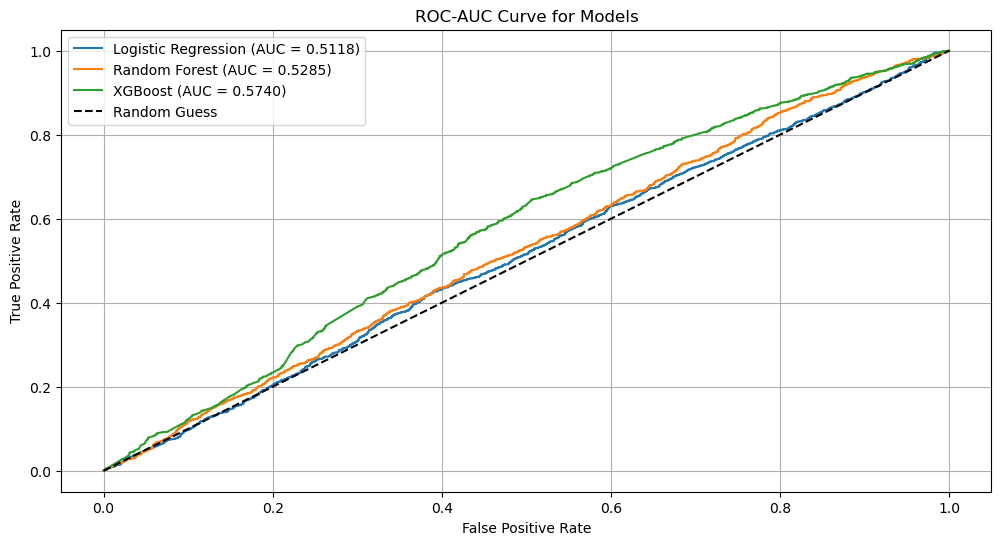

In [1469]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc, precision_recall_curve, average_precision_score

plt.figure(figsize=(12, 6))

# Loop through models to plot ROC-AUC curves
for name, model in loaded_models.items():
    if hasattr(model, "predict_proba"):  # Check if model supports probability predictions
        y_prob = model.predict_proba(X_test_pca_optimal)[:, 1]
        
        # Compute ROC curve and AUC
        fpr, tpr, _ = roc_curve(y, y_prob)
        roc_auc = auc(fpr, tpr)
        
        plt.plot(fpr, tpr, label=f"{name} (AUC = {roc_auc:.4f})")
    else:
        print(f"Skipping {name}: No probability predictions available.")

# Plot the diagonal reference line
plt.plot([0, 1], [0, 1], 'k--', label="Random Guess")

# Labels and title
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC-AUC Curve for Models")
plt.legend()
plt.grid()
plt.show()


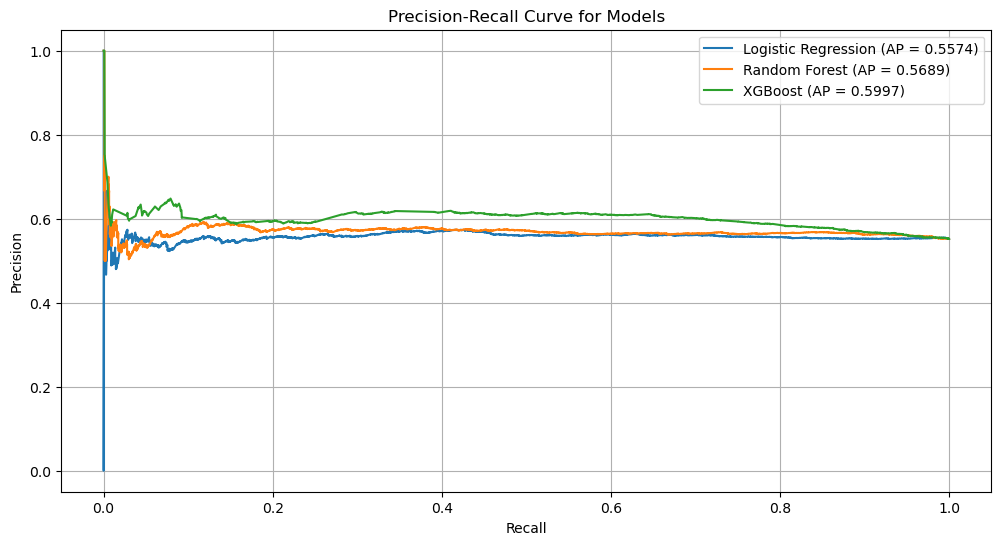

In [1471]:

# Precision-Recall Curve
plt.figure(figsize=(12, 6))
for name, model in loaded_models.items():
    if hasattr(model, "predict_proba"):
        y_prob = model.predict_proba(X_test_pca_optimal)[:, 1]
        
        # Compute Precision-Recall curve
        precision, recall, _ = precision_recall_curve(y, y_prob)
        avg_precision = average_precision_score(y, y_prob)
        
        plt.plot(recall, precision, label=f"{name} (AP = {avg_precision:.4f})")
    else:
        print(f"Skipping {name}: No probability predictions available.")

# Labels and title
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve for Models")
plt.legend()
plt.grid()
plt.show()


In [1421]:
import pandas as pd

# Make a copy to avoid modifying the original evaluation DataFrame
df_results = df_eval.copy()
df_results['Predicted'] = y_pred
company_results = df_results.groupby('Company').apply(lambda grp: pd.Series({
    'Correct': (grp['Target'] == grp['Predicted']).sum(),
    'Wrong': (grp['Target'] != grp['Predicted']).sum(),
    'Accuracy': (grp['Target'] == grp['Predicted']).mean()
})).reset_index()

print(company_results)


          Company  Correct  Wrong  Accuracy
0             ACA    111.0   18.0  0.860465
1     ADANIENT.NS     43.0   84.0  0.338583
2   ASIANPAINT.NS     84.0   43.0  0.661417
3   BAJFINANCE.NS     39.0   88.0  0.307087
4   BHARTIARTL.NS     75.0   52.0  0.590551
5        CIPLA.NS     55.0   72.0  0.433071
6    COALINDIA.NS     71.0   56.0  0.559055
7      DRREDDY.NS     70.0   57.0  0.551181
8    EICHERMOT.NS     60.0   67.0  0.472441
9       GRASIM.NS     45.0   82.0  0.354331
10     HCLTECH.NS     95.0   32.0  0.748031
11    HDFCBANK.NS    101.0   26.0  0.795276
12  HINDUNILVR.NS     64.0   63.0  0.503937
13   ICICIBANK.NS     99.0   28.0  0.779528
14  INDUSINDBK.NS     55.0   72.0  0.433071
15        INFY.NS     67.0   60.0  0.527559
16         ITC.NS     90.0   37.0  0.708661
17   KOTAKBANK.NS     73.0   54.0  0.574803
18          LT.NS     50.0   77.0  0.393701
19         M&M.NS     77.0   50.0  0.606299
20      MARUTI.NS     46.0   81.0  0.362205
21            MCB    115.0   14.

C:\Users\hp\AppData\Local\Temp\ipykernel_9264\1483941288.py:6: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  company_results = df_results.groupby('Company').apply(lambda grp: pd.Series({


In [1422]:
import pandas as pd

# Assuming df_eval already contains the actual 'Target' and you've added the predictions:
df_eval['Predicted'] = y_pred
company_results = df_eval.groupby('Company').apply(lambda grp: pd.Series({
    'Total_Target_1': (grp['Target'] == 1).sum(),
    'Total_Target_0': (grp['Target'] == 0).sum(),
    'Correctly_Predicted_Target_1': ((grp['Target'] == 1) & (grp['Predicted'] == 1)).sum(),
    'Incorrectly_Predicted_Target_1': ((grp['Target'] == 1) & (grp['Predicted'] != 1)).sum(),
    'Correctly_Predicted_Target_0': ((grp['Target'] == 0) & (grp['Predicted'] == 0)).sum(),
    'Incorrectly_Predicted_Target_0': ((grp['Target'] == 0) & (grp['Predicted'] != 0)).sum()
})).reset_index()


company_results

C:\Users\hp\AppData\Local\Temp\ipykernel_9264\1863744388.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_eval['Predicted'] = y_pred
C:\Users\hp\AppData\Local\Temp\ipykernel_9264\1863744388.py:5: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  company_results = df_eval.groupby('Company').apply(lambda grp: pd.Series({


,Company,Total_Target_1,Total_Target_0,Correctly_Predicted_Target_1,Incorrectly_Predicted_Target_1,Correctly_Predicted_Target_0,Incorrectly_Predicted_Target_0
0,ACA,111,18,111,0,0,18
1,ADANIENT.NS,43,84,43,0,0,84
2,ASIANPAINT.NS,85,42,84,1,0,42
3,BAJFINANCE.NS,38,89,38,0,1,88
4,BHARTIARTL.NS,75,52,75,0,0,52
5,CIPLA.NS,55,72,55,0,0,72
6,COALINDIA.NS,71,56,71,0,0,56
7,DRREDDY.NS,70,57,70,0,0,57
8,EICHERMOT.NS,61,66,60,1,0,66
9,GRASIM.NS,45,82,45,0,0,82


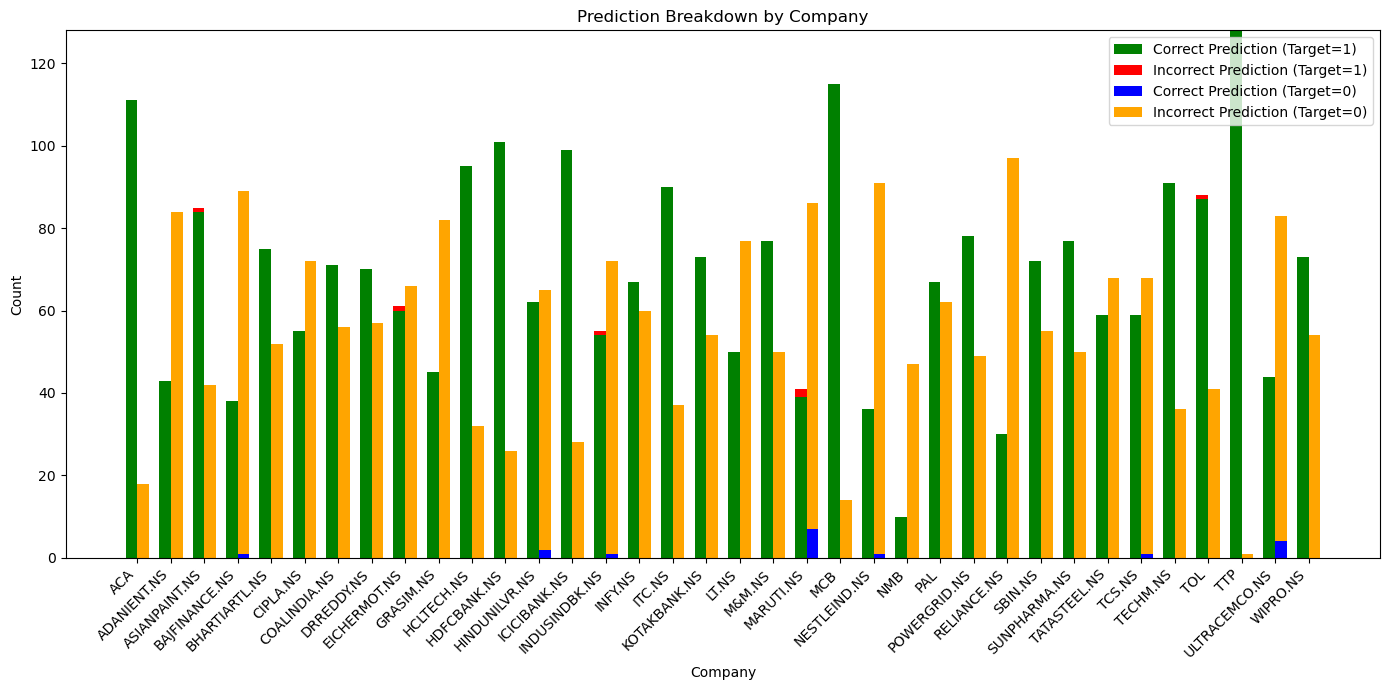

In [1437]:
import matplotlib.pyplot as plt
import numpy as np

# Get the list of companies and create an index for the x-axis
companies = company_results['Company']
x = np.arange(len(companies))
width = 0.35  # width of each bar group

# For Target=1 predictions (left bars)
correct_target_1 = company_results['Correctly_Predicted_Target_1']
incorrect_target_1 = company_results['Incorrectly_Predicted_Target_1']

# For Target=0 predictions (right bars)
correct_target_0 = company_results['Correctly_Predicted_Target_0']
incorrect_target_0 = company_results['Incorrectly_Predicted_Target_0']

# Create the plot
fig, ax = plt.subplots(figsize=(14, 7))

# Plot the Target=1 bars (positioned at x - width/2)
bar1 = ax.bar(x - width/2, correct_target_1, width, 
              label='Correct Prediction (Target=1)', color='green')
bar2 = ax.bar(x - width/2, incorrect_target_1, width, 
              bottom=correct_target_1, label='Incorrect Prediction (Target=1)', color='red')

# Plot the Target=0 bars (positioned at x + width/2)
bar3 = ax.bar(x + width/2, correct_target_0, width, 
              label='Correct Prediction (Target=0)', color='blue')
bar4 = ax.bar(x + width/2, incorrect_target_0, width, 
              bottom=correct_target_0, label='Incorrect Prediction (Target=0)', color='orange')

# Customize the x-axis with company names
ax.set_xticks(x)
ax.set_xticklabels(companies, rotation=45, ha='right')
ax.set_xlabel('Company')
ax.set_ylabel('Count')
ax.set_title('Prediction Breakdown by Company')

# Add a legend
ax.legend()

plt.tight_layout()
plt.show()


# THANK YOU FOR READING 